# Mak et al, 2015

## Introduction

In this notebook we will identify PPMI subjects to reproduce the following paper:

<div class="alert alert-block alert-success"> E. Mak et al., <a href="https://academic.oup.com/brain/article/138/10/2974/2468704?login=false" style="text-decoration: none;">“Baseline and longitudinal grey matter changes in newly diagnosed Parkinson’s disease: ICICLE-PD study,”</a> Brain, vol. 138, no. 10, pp. 2974–2986, 2015.
</div>

This study involved 105 subjects with newly diagnosed idiopathic Parkinson’s disease (PD) and 37 healthy matched controls. 

Among the 105 PD subjects, they classified 39 subjects as PD with mild cognitive impairment (PD-MCI) and 66 subjects as PD with no cognitive impairment (PD-NC).

The demographics and clinical characteristics were as follows (table extracted from the paper):

<img src="images/cohort_table.jpeg"/>

The subjects had a serial 3 T structural magnetic resonance imaging (MRI) scans with clinical and neuropsychological assessments at baseline and, at 18 months follow-up.

These MRI were processed with Freesurfer, an image processing software, to measure the cortical thickness and subcortical volumes at baseline and follow-up. 

The key result of the paper reveals that PD-MCI shows more extensive atrophy and greater percentage of cortical thinning compared to PD-NC, as illustrated below in Table 2 and Figure 2C (extracted from paper) respectively. 

<img src="images/change_in_subcortical_volumes.jpeg"/>

<figure>
    
<img src="images/change_in_cortical_thinning.jpg"/>

<figcaption>
    <b>Figure 2C. Vertex-wise comparisons of percentage change in cortical thinning over 18 months.</b>
    The colour bar shows the logarithmic scale of P-values (−log10). Lh = left hemisphere; Rh = right hemisphere.</figcaption>

</figure>


The rest of this notebook aims at reproducing these results using the PPMI dataset.

## Importing modules

First, let's initialize the notebook by installing software dependencies and importing libraries that we're going to use.

In [1]:
import os
import rich
import warnings
import numpy as np
import pandas as pd
import livingpark_utils
from pingouin import ancova
from rich.table import Table
from itertools import product
import matplotlib.pyplot as plt
from rich.console import Console
from itertools import combinations
from collections import namedtuple
from collections import defaultdict
from collections.abc import Iterable
from livingpark_utils.scripts import run
from livingpark_utils.maketal import maketal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

inputs_dir = os.path.join(os.getcwd(), "inputs/study_files")
data_dir = os.path.join(os.getcwd(), "data")

warnings.filterwarnings('ignore')

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

removing link inputs
removing link outputs
This notebook was run on 2022-12-14 18:28:01 UTC +0000


## Cohort Preparation

The first step in reproducing the paper is to build a PPMI cohort that looks the closest to Table 1. For this, we will use PPMI Study Data files.

## PPMI study data files download

The required PPMI study files to build the cohort are:

|Files|Used to retrieve|
|:---|:---|
|Demographics | gender|
|Age at visit | age|
|Socio-Economics| years of education|
|Participant Status | PD subjects and healthy controls|
|Primary Clinical Diagnosis | subjects with no PD nor other neurological disorder |
|Cognitive Categorization | PD-MCI and PD-NC subjects| 
|PD Diagnosis History | disease duration| 
|MDS UPDRS Part III | Hoehn and Yahr scores|
|LEDD Concomitant Medication Log | LEDD scores|
|Montreal Cognitive Assessment MoCA | MoCA and MMSE scores|
|Geriatric Depression Scale Short Version | GDS scores|


We will use the LivingPark utils library to download these files from the notebook. 

In [2]:
required_files = [
    "Demographics.csv",
    "Age_at_visit.csv",
    "MDS_UPDRS_Part_III.csv",
    "Socio-Economics.csv",
    "LEDD_Concomitant_Medication_Log.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "Cognitive_Categorization.csv",
    "Participant_Status.csv",
    "Primary_Clinical_Diagnosis.csv",
    "Geriatric_Depression_Scale__Short_Version_.csv"
]

utils.download_ppmi_metadata(required_files)

Download skipped: No missing files!


/var/folders/g_/7m_qjcs17b99gvb98v3t1gh00000gn/T/ipykernel_6453/207018061.py:15: DeprecationWarning: Call to deprecated function download_ppmi_metadata.
This function will be remove in future version.
Moved to function `livinpark_utils::LivingParkUtils::get_study_files`.
  utils.download_ppmi_metadata(required_files)


## LivingPark utility notebook download 

We will also import notebooks from LivingPark utils to clean data which produce the following files:

* <code>MRI_info.csv</code>: contains 3D T1-weighted images by visit
* <code>MDS_UPDRS_Part_III_clean.csv</code>: contains cleaned-up PDSTATE and PDTRTMNT

In [3]:
# from livingpark_utils.scripts import mri_metadata
# run.mri_metadata()

This notebook was run on 2022-12-14 18:28:01 UTC +0000
File downloaded


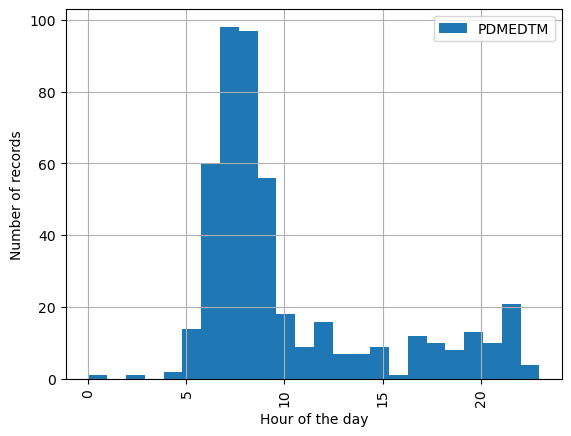

Removed 40 records where PDSTATE=ON and EXAMTM<PDMEDTM
Number of removed records: 5
Found 0 records in Case 3.a
Removed 1 record(s) with missing EXAMTM or PDMEDTM
Cleaned file saved in MDS_UPDRS_Part_III_clean.csv
True


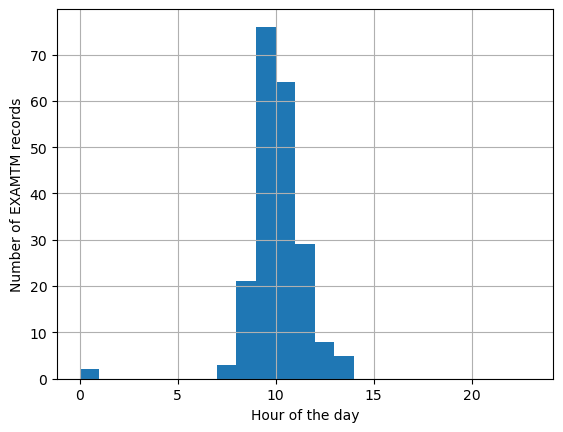

In [4]:
from livingpark_utils.scripts import pd_status
run.pd_status()

## Cohort Matching

Now that we have all the required files, we will start by preparing the data for cohort matching.

In [5]:
# Styling visualization plots
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['axes.facecolor'] = '#F2F5F9'
plt.rcParams['axes.edgecolor'] = 'none'
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.color'] = 'white'
plt.rcParams["figure.autolayout"] = True
color = '#2A2A2A'

### Demographics Characteristics

### Cohort Definition

First, we will extract participants defined as healthy controls and diagnosed with Parkinson's disease.

We obtain the following distribution of participants across the cohort in the PPMI dataset:

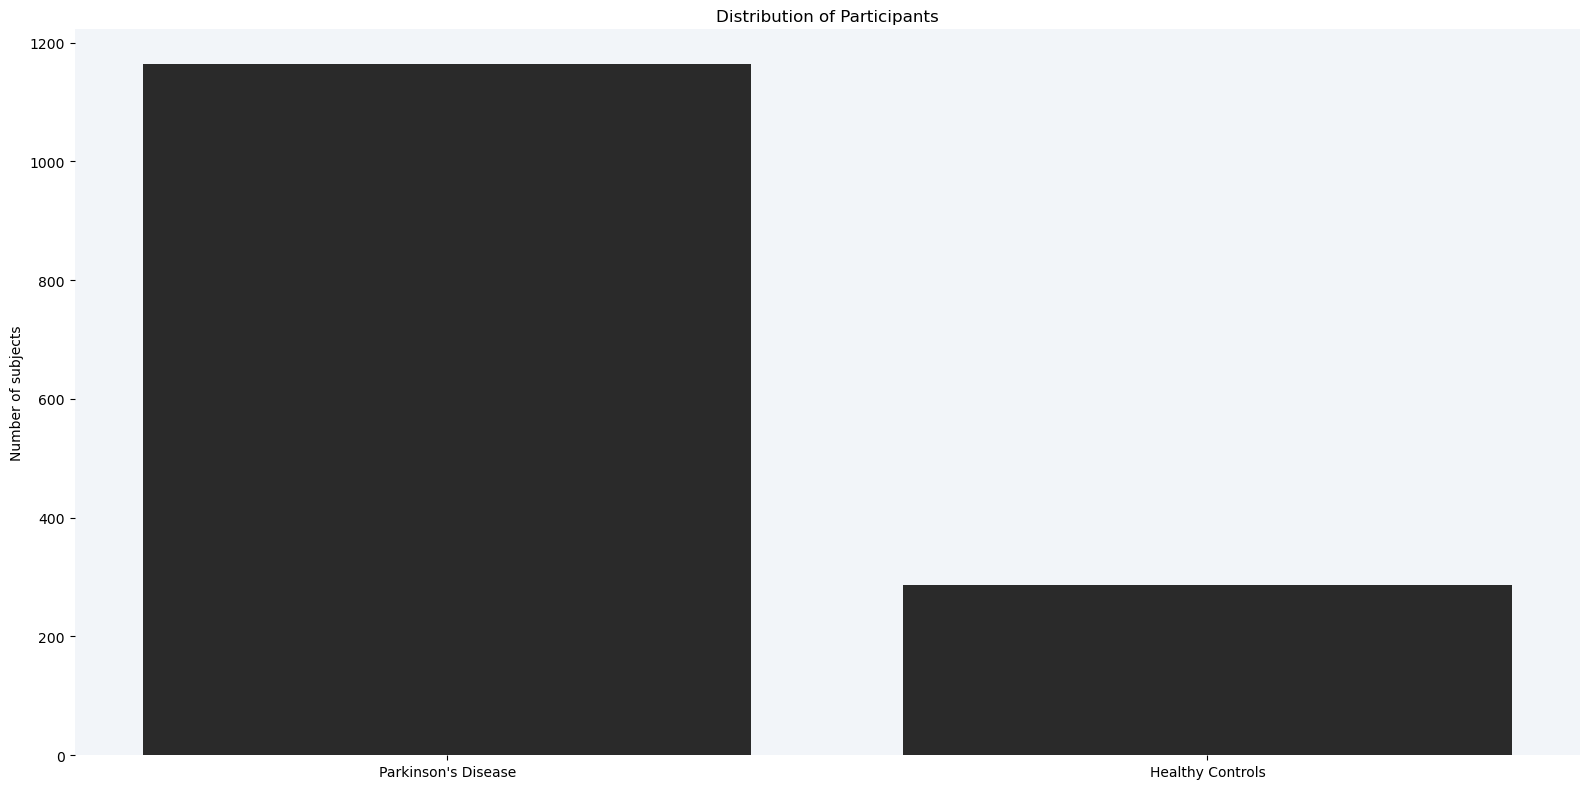

In [6]:
participants = pd.read_csv(os.path.join(inputs_dir, "Participant_Status.csv"), usecols=["PATNO", "COHORT"])
participants = participants[participants["COHORT"].isin([1, 2])] # Only keep PD(1) and HC(2).

pd_patients = participants[participants["COHORT"] == 1] # Dataframe with PD only
hc = participants[participants["COHORT"] == 2] # Dataframe with HC only

prim_diag = pd.read_csv(os.path.join(inputs_dir, "Primary_Clinical_Diagnosis.csv"), usecols=["PATNO", "PRIMDIAG"])

# Only keep no PD nor other neurological disorder (PRIMDIAG 17)
prim_diag = prim_diag[prim_diag["PRIMDIAG"].isin([17])].drop_duplicates()

# If patient status is both PRIMDIAG 17 and COHORT 2, 
# then patient is defined as healthy control
hc = hc.merge(prim_diag, on=["PATNO"]).drop_duplicates().drop(columns=['PRIMDIAG'])

# Merge PD, HC and PRIMDIAG
cohort_def = pd.concat([pd_patients, hc])
cohort_def = cohort_def.sample(frac=1, random_state=42)
cohort_def.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

cohort = cohort_def.groupby(["COHORT"]).size()
plt.bar(["Parkinson's Disease", "Healthy Controls"], cohort.values, color=color)
plt.ylabel("Number of subjects")
plt.title("Distribution of Participants");

### Cognitive State

The original study differentiates between PD patients with and without MCI. 

We will consult PPMI's cognitive categorization to obtain its distribution. 

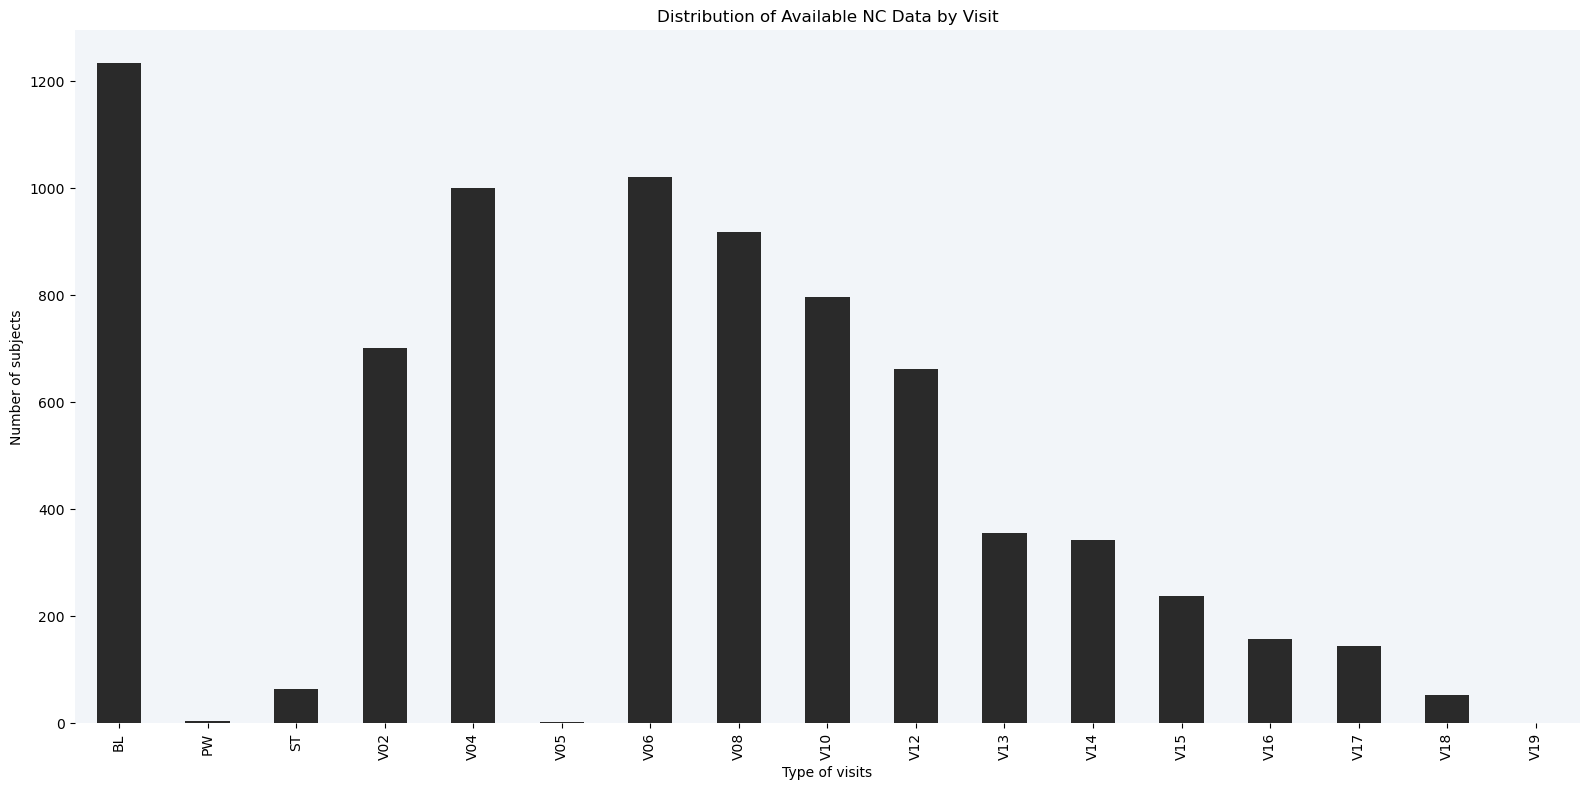

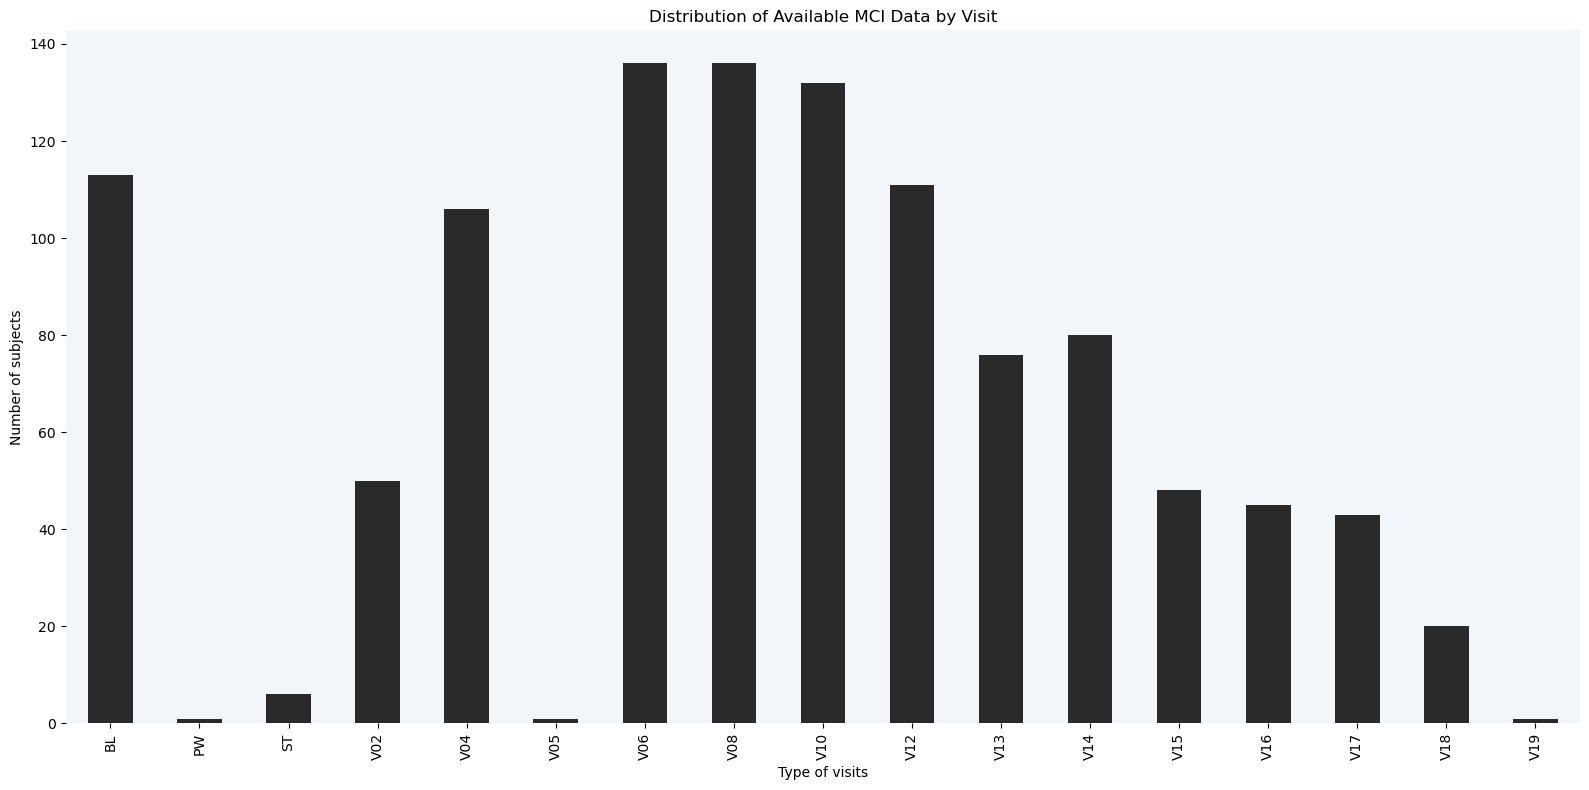

In [7]:
cogstate_df = pd.read_csv(os.path.join(inputs_dir,"Cognitive_Categorization.csv"),
                          usecols=["PATNO", "EVENT_ID", "COGSTATE"])
# Drop nan
cogstate_df = cogstate_df[cogstate_df["COGSTATE"].notna()] 
# Dropping all subjects with PDD
cogstate_df = cogstate_df[cogstate_df["COGSTATE"] != 3] 

cogstate = cogstate_df.groupby(["COGSTATE", "EVENT_ID"])["PATNO"].nunique().rename({1: "NC", 2: "MCI"})
shared_index = np.intersect1d(cogstate["NC"].index, cogstate["MCI"].index)
cogstate["NC"][shared_index].plot.bar(title="Distribution of Available NC Data by Visit", color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Type of visits")
plt.show()
cogstate["MCI"][shared_index].plot.bar(title="Distribution of Available MCI Data by Visit", color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Type of visits")
plt.show()

Types of visits expressed as: BL-Baseline, PW-Premature Withdrawal, ST-Symptomatic Therapy, V<em>xx</em>-Visit <em>xx</em>

Based on the graph above, we see that the number of subjects with NC is significantly more. Therefore we will make sure to obtain MCI patients before NC ones.

### Age at visit

The patient's age was recorded at each visit. To keep it simple, we will only show the age distribution at baseline while considering the age at specific visits for the cohort.

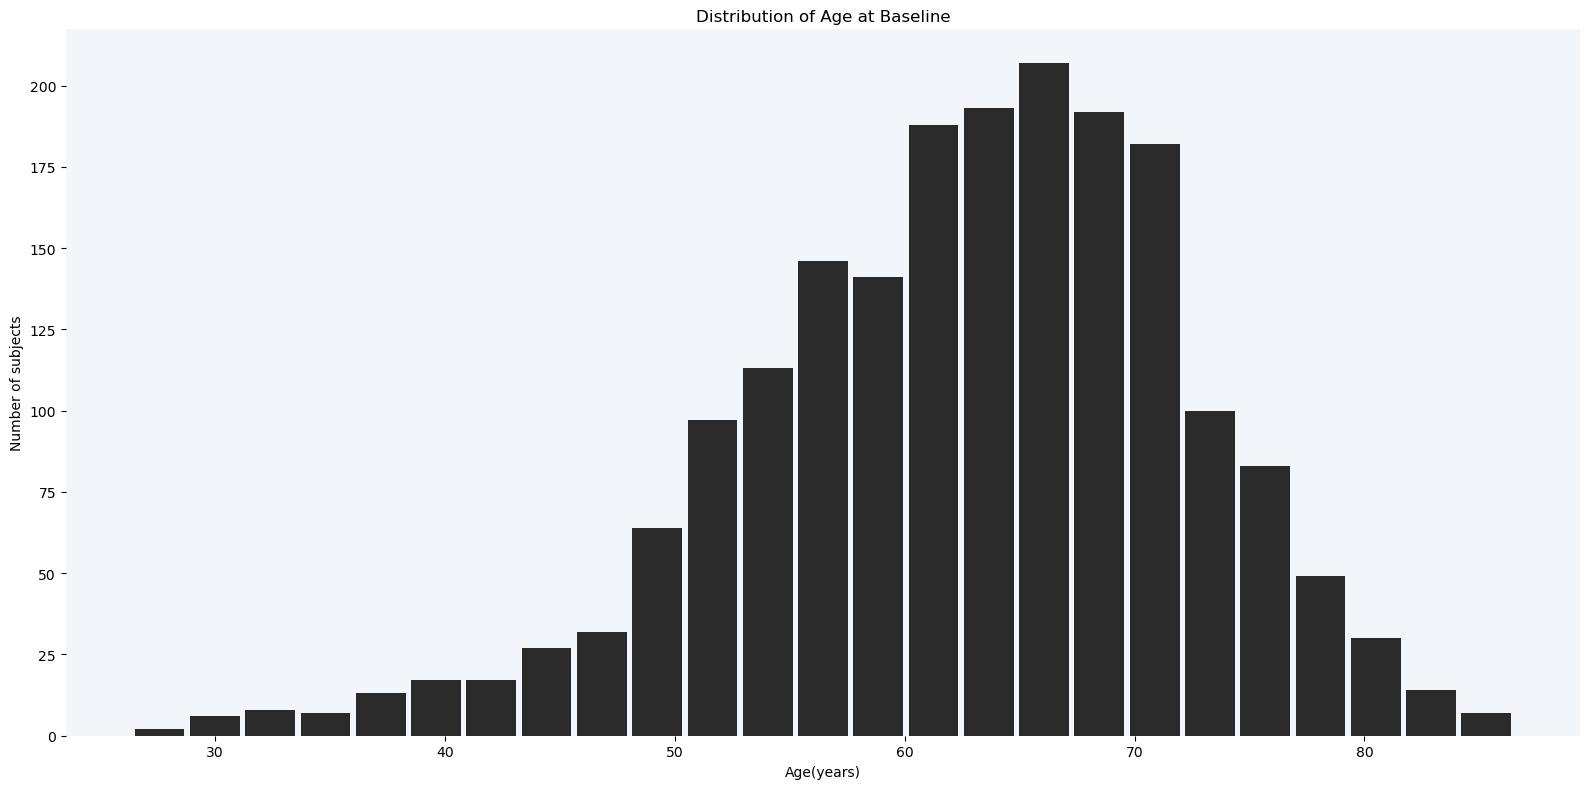

In [8]:
age_df = pd.read_csv(os.path.join(inputs_dir, "Age_at_visit.csv"),
                     usecols=["PATNO", "EVENT_ID", "AGE_AT_VISIT"])

age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.xlabel('Age(years)')
plt.ylabel('Number of subjects')
plt.title("Distribution of Age at Baseline");

In [9]:
# Age range at baseline
print("Age Range: ", age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].min(), "-", 
      age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].max())

Age Range:  26.4 - 86.5


### Gender

We will look at PPMI's demographics to get the gender distribution.

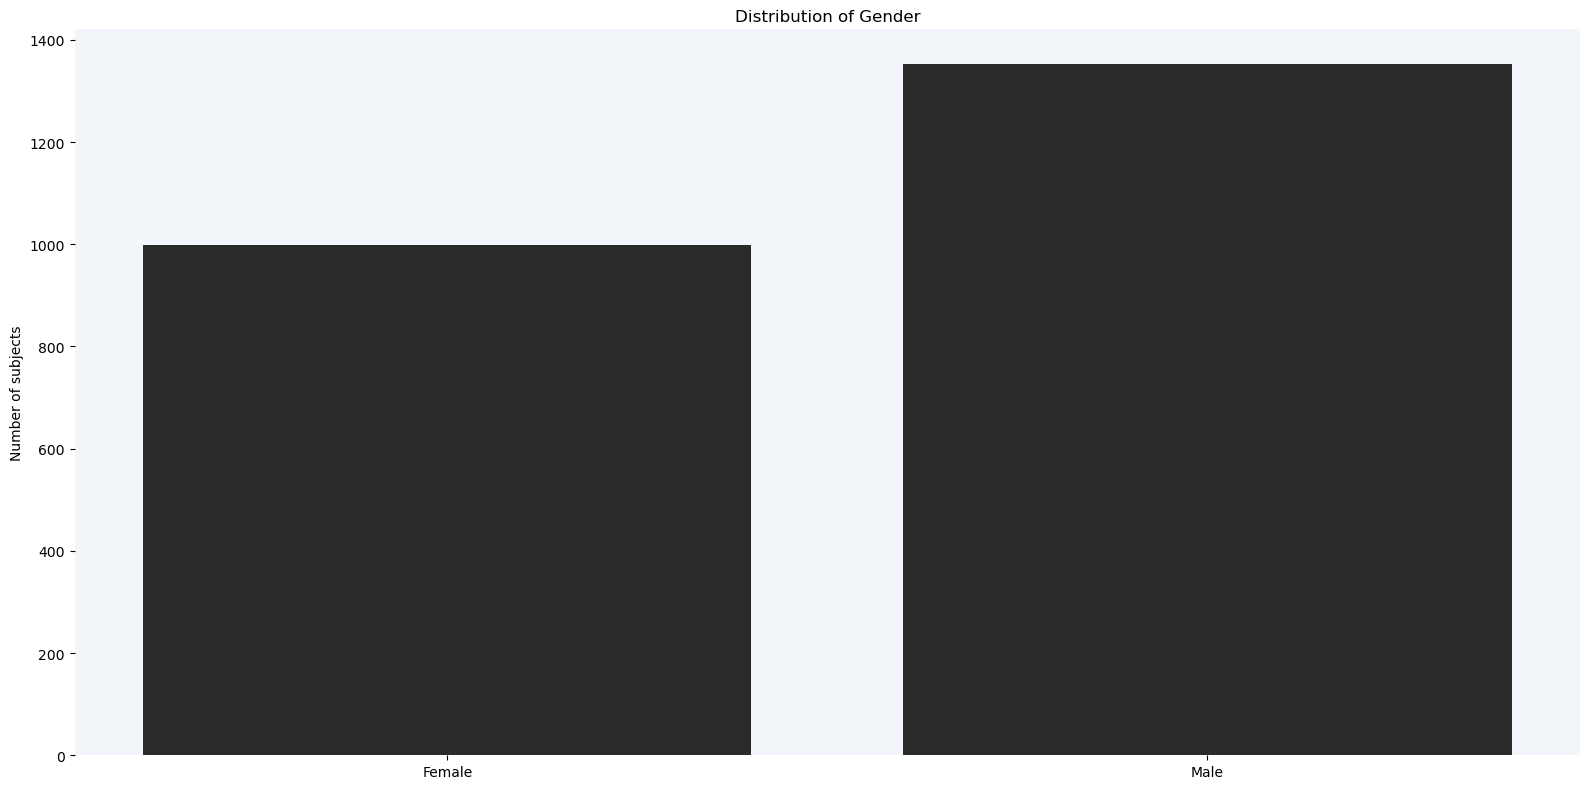

In [10]:
demo_df = pd.read_csv(os.path.join(inputs_dir,"Demographics.csv"), usecols=["PATNO", "SEX"])
demo_df["SEX"] = demo_df["SEX"].astype(int)

gender = demo_df.groupby("SEX").size().rename({0: "Female", 1: "Male"})

plt.bar(gender.index, gender.values, color=color)
plt.ylabel("Number of subjects")
plt.title("Distribution of Gender");

### Education

While looking at PPMI's socioeconomics, we notice that in the graph below, the education years was mostly recorded at screening. Thus, we will only consider the latter as the other visits might limit the possibility to perform data aggregation for the cohort matching.

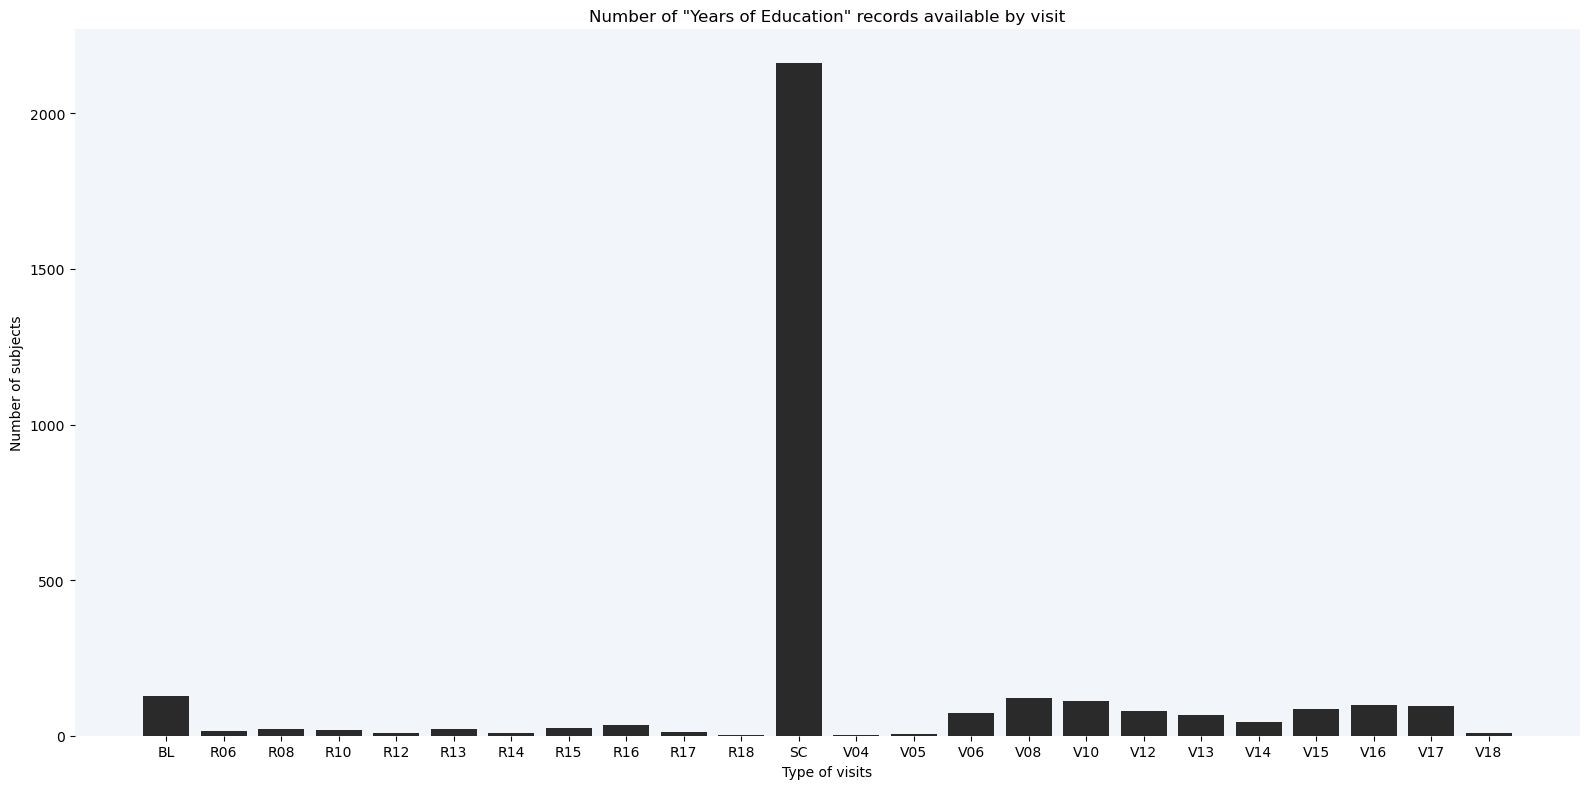

In [11]:
socioecon_df = pd.read_csv(os.path.join(inputs_dir,"Socio-Economics.csv"), usecols=["PATNO", "EVENT_ID", "EDUCYRS"])
events = socioecon_df.groupby("EVENT_ID").size()

plt.bar(events.index.astype(str), events.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Type of visits")
plt.title("Number of \"Years of Education\" records available by visit");

We obtain the following distribution of education years at screening:

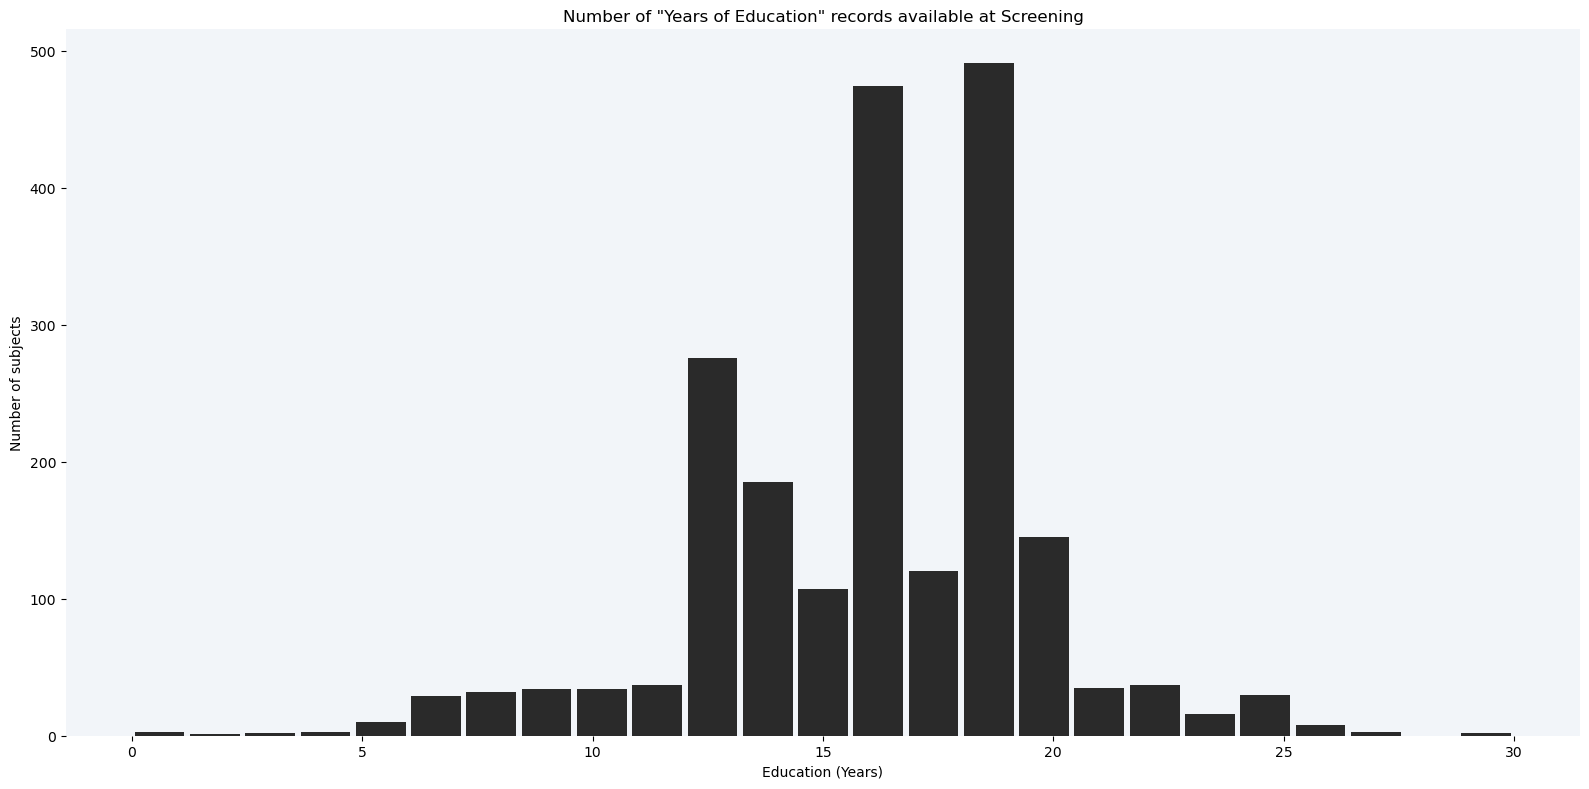

In [12]:
socioecon_df = socioecon_df[socioecon_df["EVENT_ID"] == "SC"]
socioecon_df = socioecon_df[["PATNO", "EDUCYRS"]]

socioecon_df["EDUCYRS"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.ylabel("Number of subjects")
plt.xlabel("Education (Years)")
plt.title("Number of \"Years of Education\" records available at Screening");

In [13]:
# Range of education years
print("Education Years Range: ", socioecon_df["EDUCYRS"].min(), "-", 
      socioecon_df["EDUCYRS"].max())

Education Years Range:  0.0 - 30.0


### Disease duration

Similar to the previous section, we will only use PD diagnosis duration taken at screening since it has the most records as shown in the graph below. 

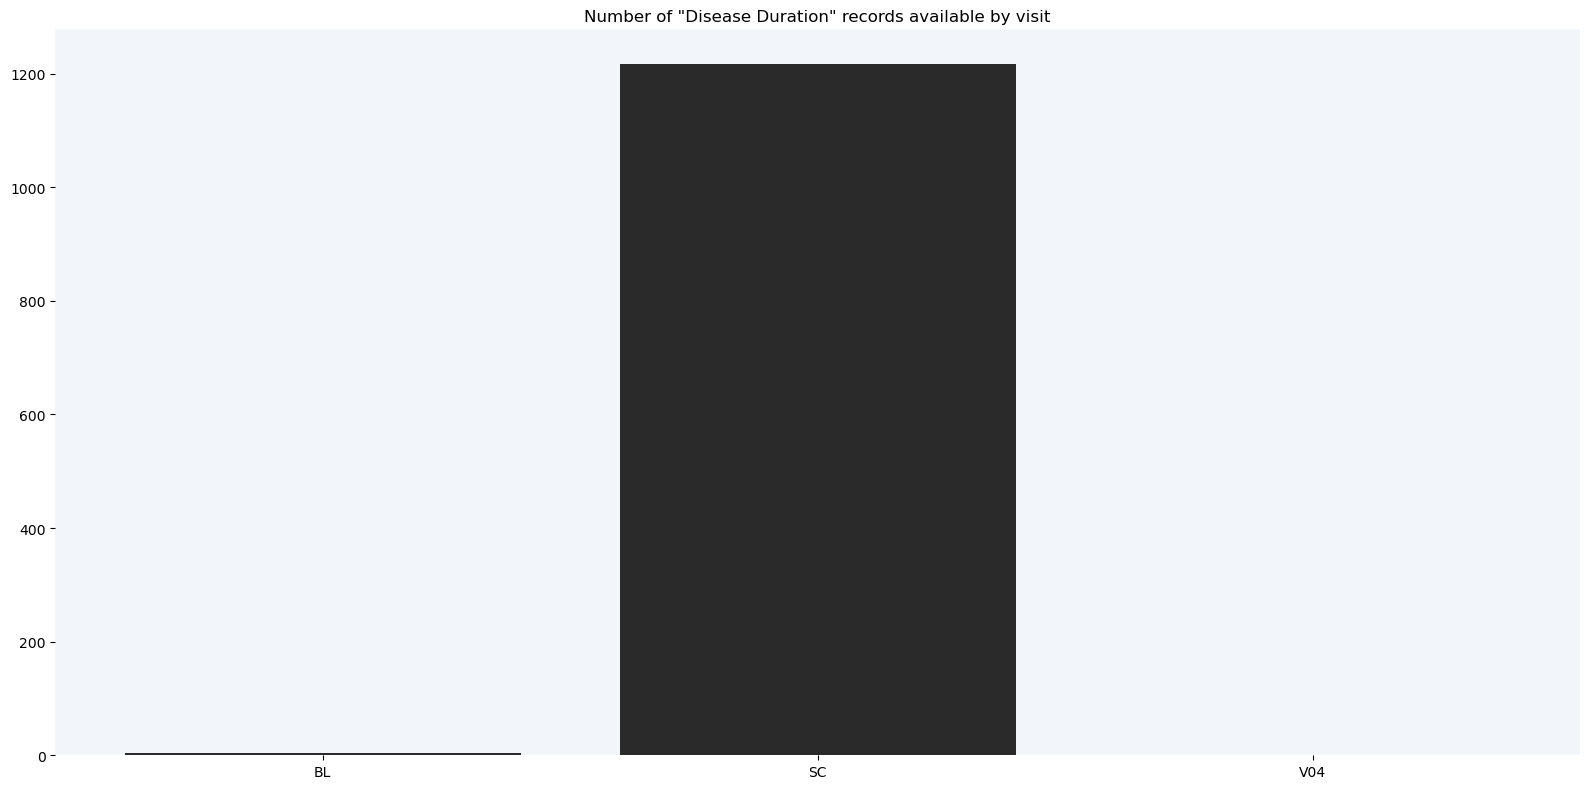

In [14]:
pddxdt_df = pd.read_csv(os.path.join(inputs_dir,"PD_Diagnosis_History.csv"), usecols=["PATNO", "EVENT_ID", "PDDXDT"])

events = pddxdt_df.groupby("EVENT_ID").size()

plt.bar(events.index.astype(str), events.values, color=color)
plt.title("Number of \"Disease Duration\" records available by visit");

We obtain the following distribution of disease duration:

Download skipped: No missing files!


/var/folders/g_/7m_qjcs17b99gvb98v3t1gh00000gn/T/ipykernel_6453/2516966790.py:1: DeprecationWarning: Call to deprecated function disease_duration.
This function will be remove in future version.
Moved to module `livingpark_utils.dataset.ppmi`.
  pdxdur_df = utils.disease_duration()


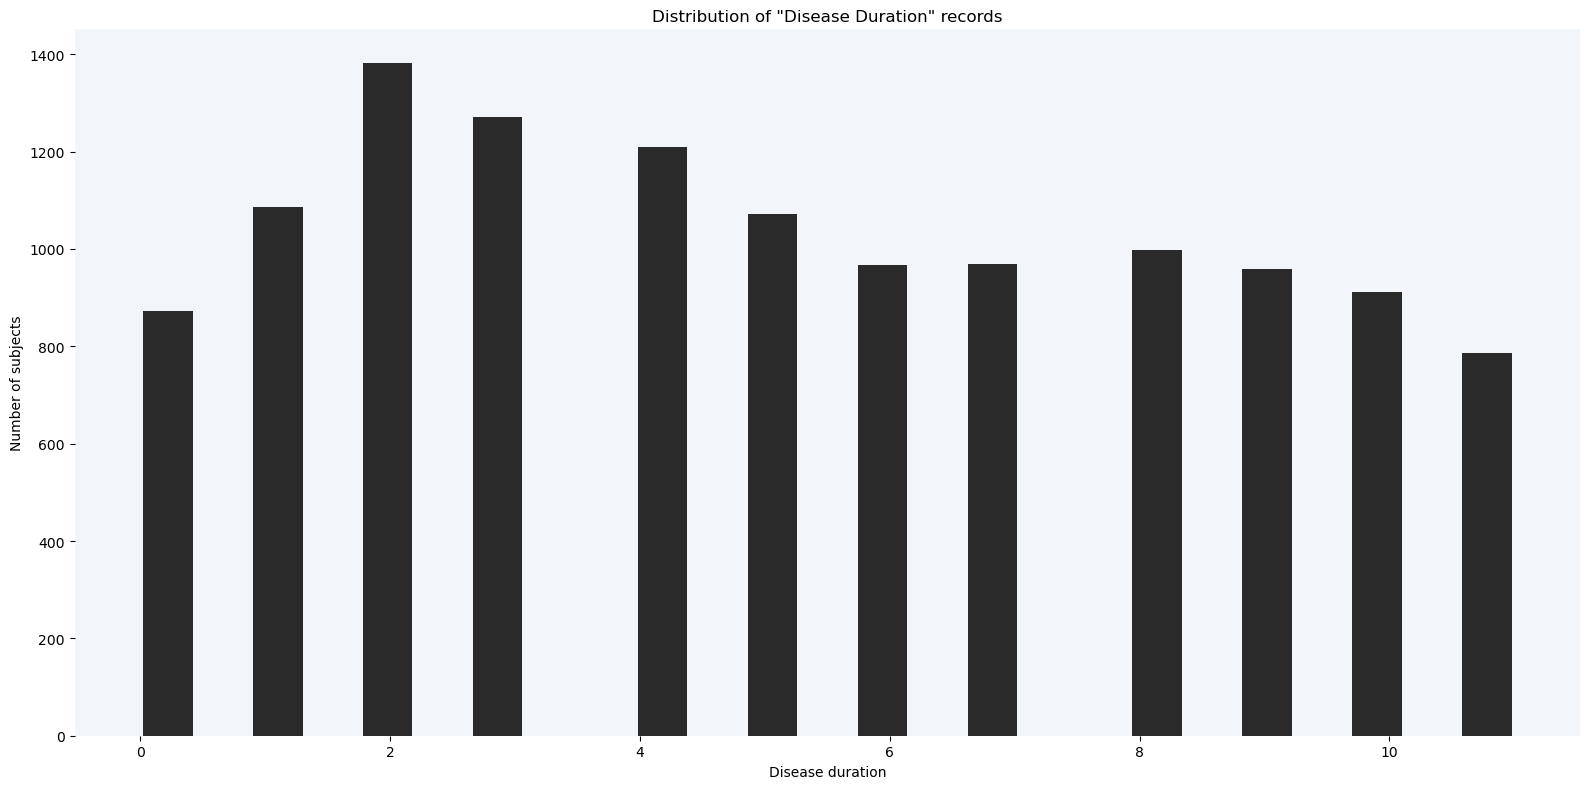

In [15]:
pdxdur_df = utils.disease_duration()

pdxdur_df["PDXDUR"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.ylabel("Number of subjects")
plt.xlabel("Disease duration")
plt.title("Distribution of \"Disease Duration\" records");

### Clinical Characteristics
### Levodopa equivalent daily dose (LEDD)

Likewise, as seen in the graph below, LEDD was mostly recorded at logs. Therefore, we will only consider LEDD at logs.

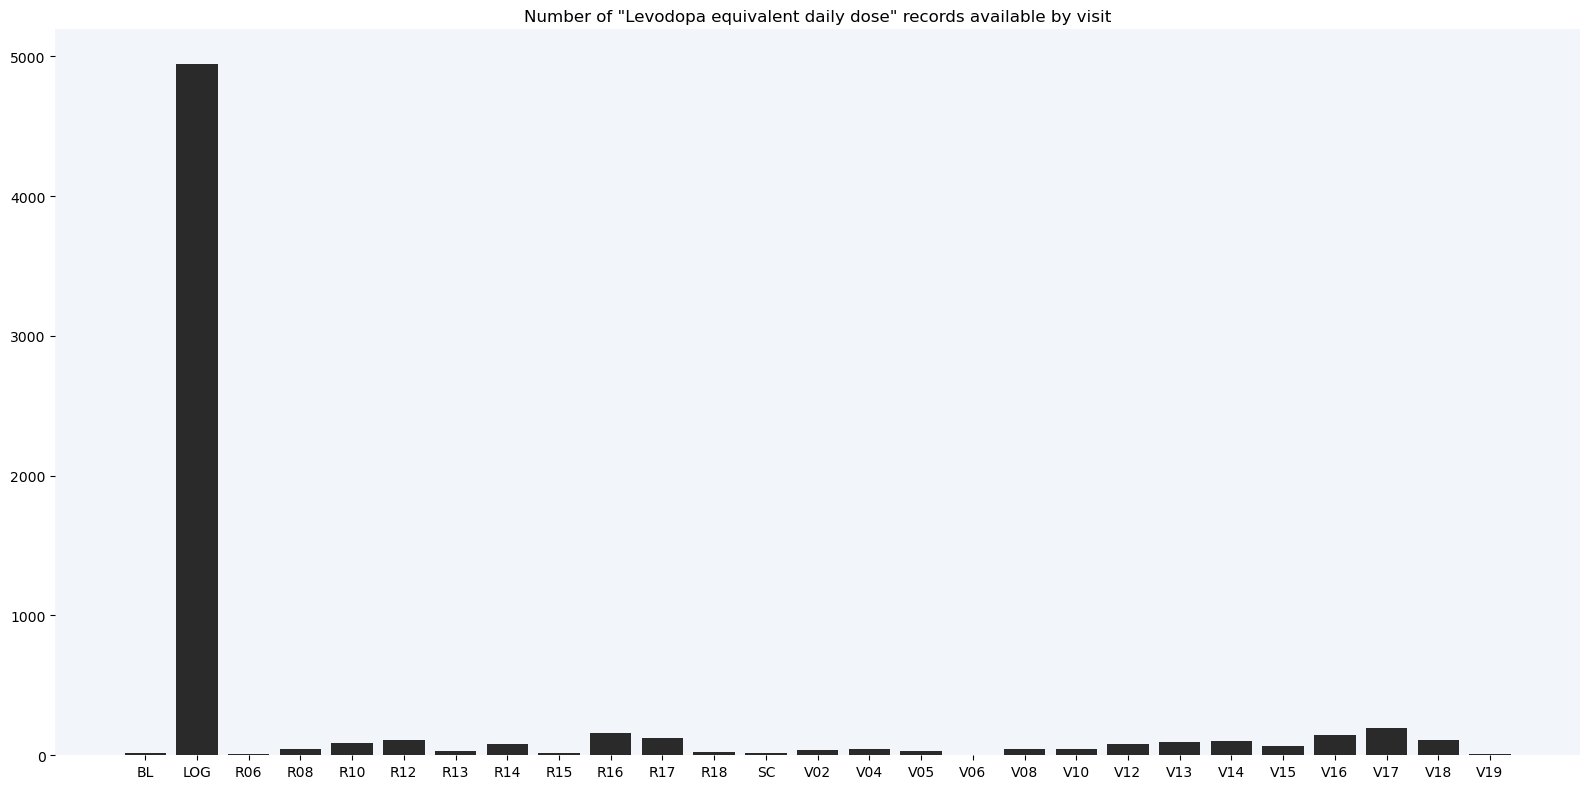

In [16]:
ledd_df = pd.read_csv(os.path.join(inputs_dir,"LEDD_Concomitant_Medication_Log.csv"),
                     usecols=["PATNO", "EVENT_ID", "LEDD"])

events = ledd_df.groupby(["EVENT_ID"]).size()
plt.bar(events.index.astype(str), events.values, color=color)
plt.title("Number of \"Levodopa equivalent daily dose\" records available by visit");

The distribution of LEDD is as follows:

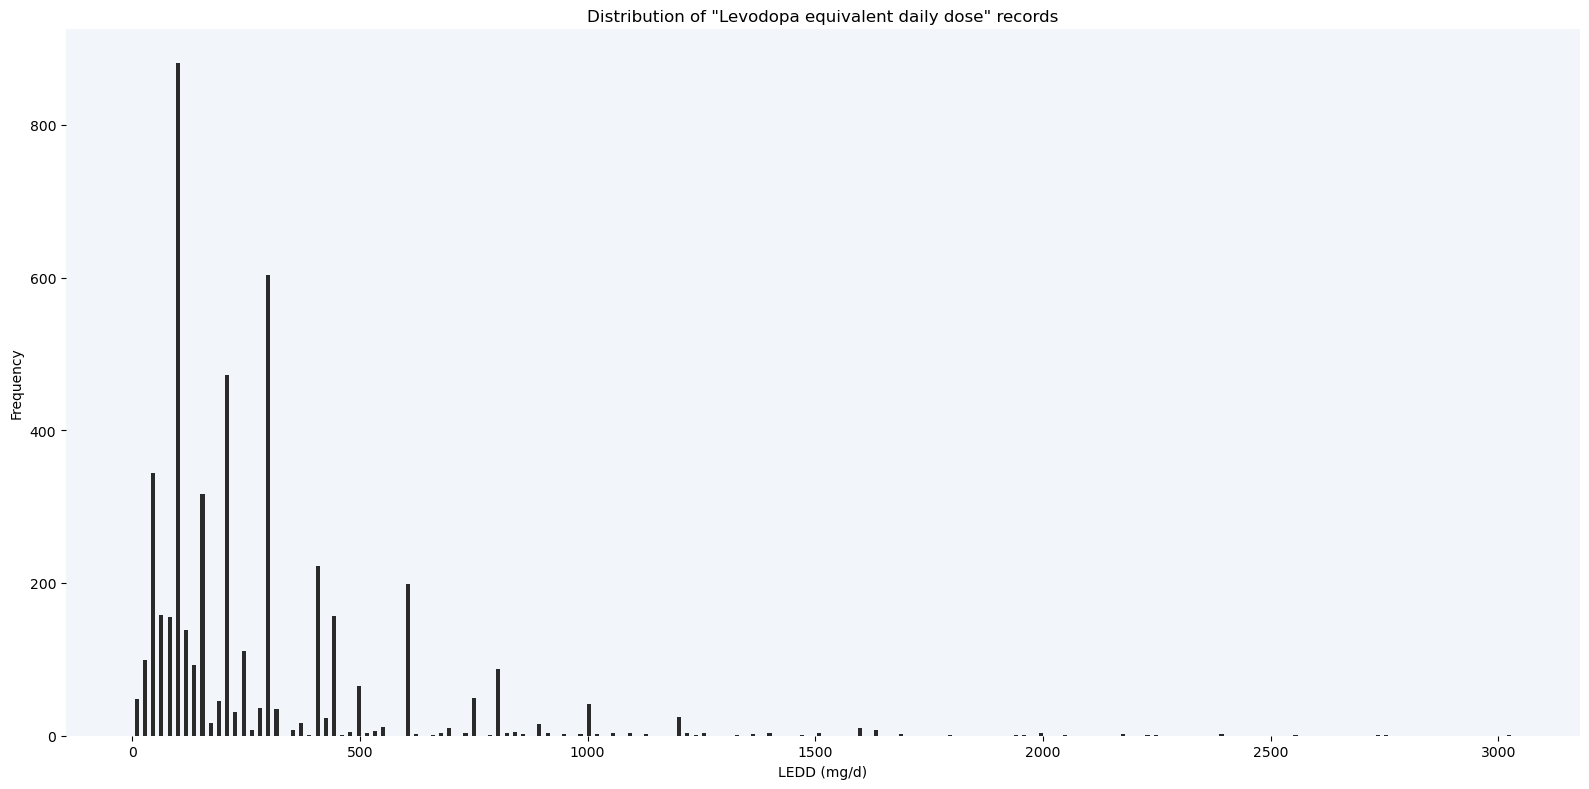

In [17]:
ledd_df = ledd_df[ledd_df["EVENT_ID"] == "LOG"]
ledd_df = ledd_df[["PATNO", "LEDD"]]

# For PD medications except COMT inhibitors, the column LEDD will show the value of the
# Levodopa equivalent dose for that medication. 

# For COMT inhibitors, the column LEDD will read “LD x 0.33” (for Entacapone) or “LD x 0.5” 
# (for Tolcapone). 

# To find the LEDD for COMT inhibitors, first find the total dose of Levodopa only, 
# and then multiply the Levodopa dose by either 0.33 or 0.5 as instructed. 

# Since Levodopa dose is mostly missing we will drop those.

ledd_df = ledd_df[ledd_df["LEDD"].notna()] # Drop nan
ledd_df = ledd_df[ledd_df["LEDD"] != "LD x 0.33"] # Drop LD x 0.33
ledd_df = ledd_df[ledd_df["LEDD"] != "LD x 0.5"] # Drop LD x 0.5

ledd_df["LEDD"] = ledd_df["LEDD"].astype('float32')

ledd = ledd_df.groupby(["LEDD"]).size()

plt.hist(ledd_df['LEDD'], zorder=3, color=color, bins=len(ledd.index),rwidth=0.5)
plt.xlabel('LEDD (mg/d)')
plt.ylabel('Frequency')
plt.title("Distribution of \"Levodopa equivalent daily dose\" records");

### Hoehn and Yahr staging (H&Y)

We obtain the following distribution of H&Y scores:

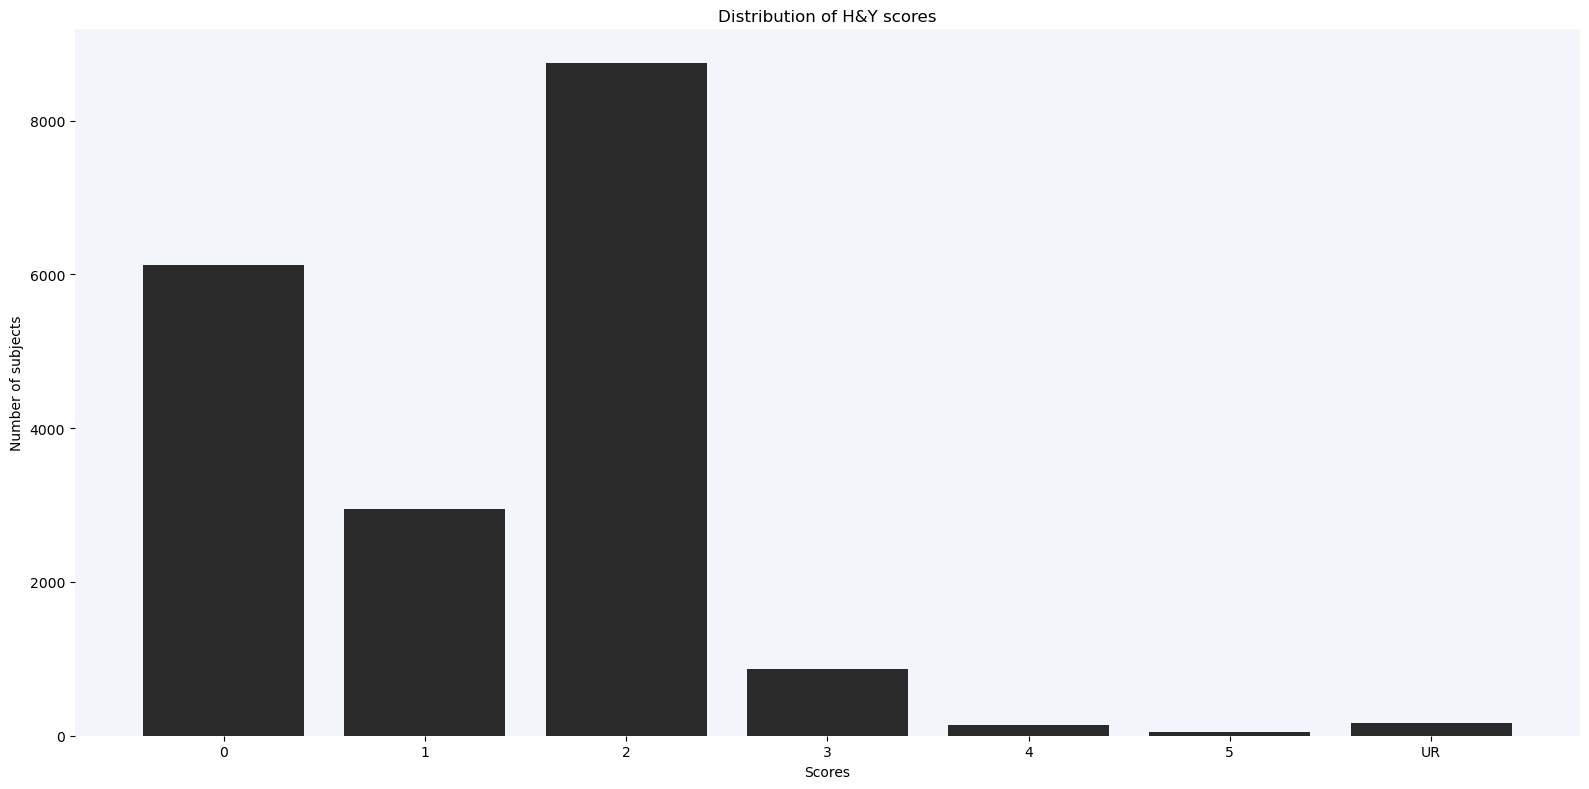

In [18]:
updrs3_df = pd.read_csv(os.path.join(data_dir,"MDS_UPDRS_Part_III_clean.csv"),
                     usecols=["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"])
updrs3_df = updrs3_df[updrs3_df["NHY"].notna()] # Drop nan
updrs3 = updrs3_df.groupby(["NHY"], dropna=False).size()

plt.bar(updrs3.index.astype(str), updrs3.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Scores")
plt.title("Distribution of H&Y scores");

<em>UR expressed as Unable to Rate.</em>

We will remove the patients whose examiners were not able to rate the H&Y score.

In [19]:
updrs3_df = updrs3_df[updrs3_df["NHY"] != "UR"]
updrs3_df["NHY"] = pd.to_numeric(updrs3_df["NHY"])

### Unified Parkinson’s Disease Rating Scale (UPDRS III)

We obtain the following distribution of UPDRS III scores:

/var/folders/g_/7m_qjcs17b99gvb98v3t1gh00000gn/T/ipykernel_6453/4183401168.py:9: DeprecationWarning: Call to deprecated function reformat_plot_labels.
This function will be remove in future version.
Moved to module `livingpark_utils.visualization`.
  utils.reformat_plot_labels(dist, ax, 10)


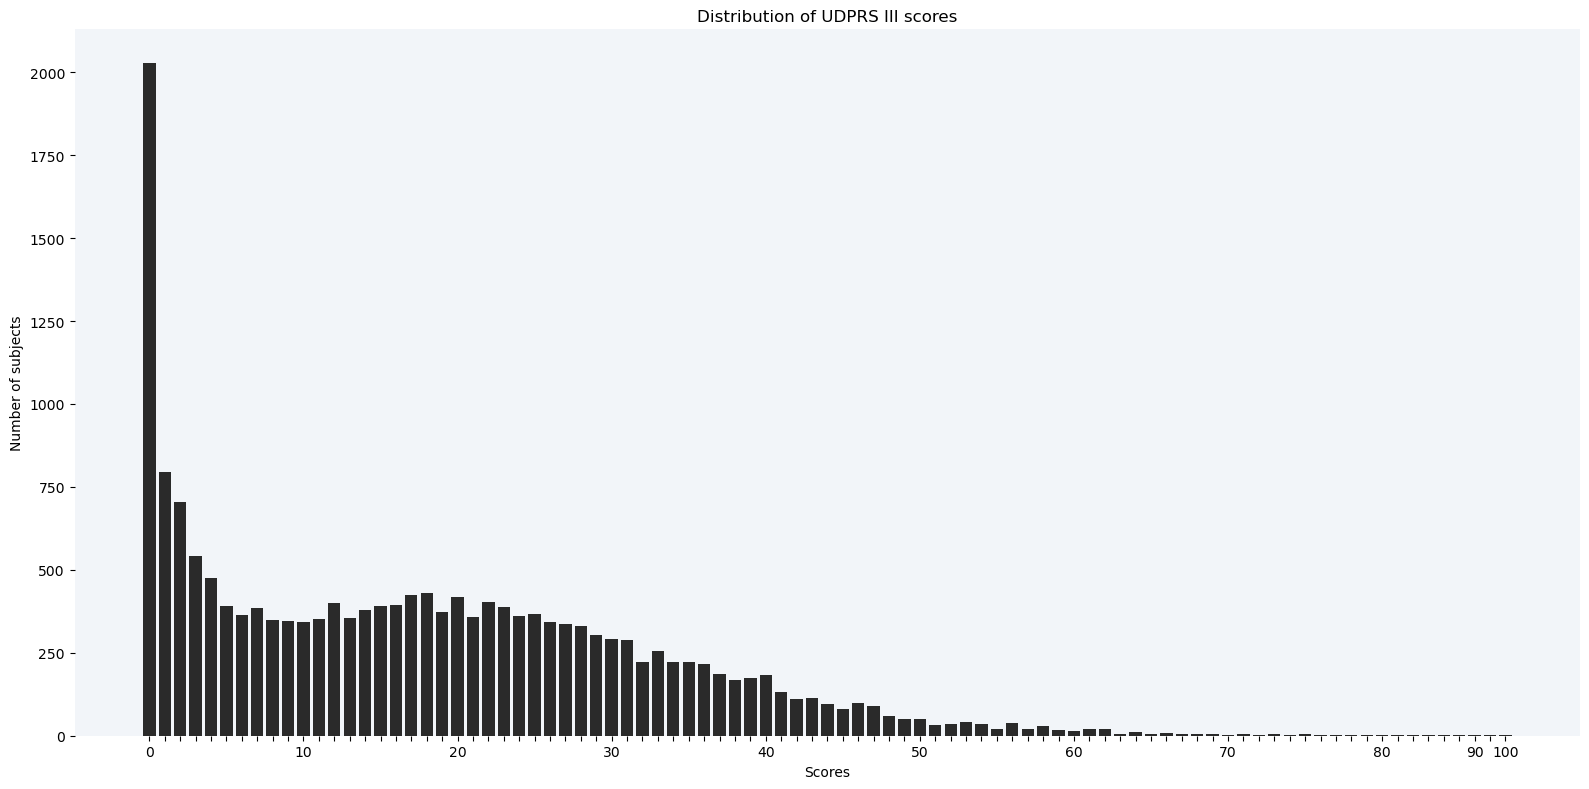

In [20]:
figure, ax = plt.subplots()

dist = updrs3_df.groupby(["NP3TOT"]).size()
plt.bar(dist.index.astype(str), dist.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Scores")
plt.title("Distribution of UDPRS III scores")

utils.reformat_plot_labels(dist, ax, 10)

### Montreal Cognitive Assessment (MoCA)

We obtain the following distribution of MoCA scores:

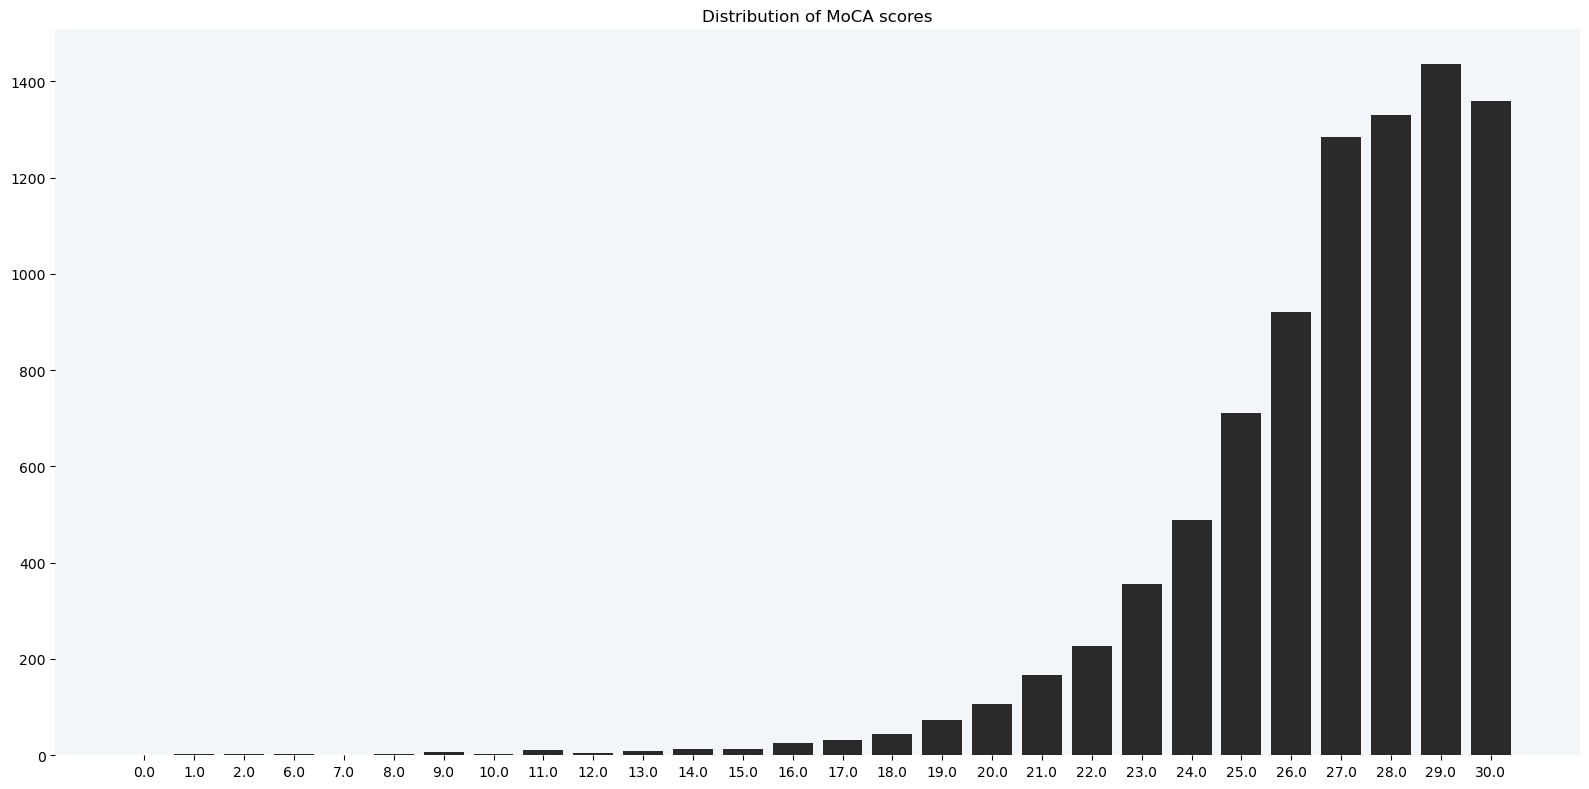

In [21]:
moca_df = pd.read_csv(os.path.join(inputs_dir,"Montreal_Cognitive_Assessment__MoCA_.csv"),
                   usecols=["PATNO", "EVENT_ID", "MCATOT"])

# Use screening instead of baseline.
moca_df = moca_df[moca_df["EVENT_ID"] != "BL"]
moca_df["EVENT_ID"].mask(moca_df["EVENT_ID"] == "SC", "BL", inplace=True)

moca = moca_df.groupby(["MCATOT"]).size()
plt.bar(moca.index.astype(str), moca.values, color=color)
plt.title("Distribution of MoCA scores");

### Mini-Mental State Examination (MMSE)

We obtain the following distribution of MMSE scores:

/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pandas/core/apply.py:1156: DeprecationWarning: Call to deprecated function moca2mmse.
This function will be remove in future version.
Moved to module `livingpark_utils.clinical`.
  mapped = lib.map_infer(
/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pandas/core/apply.py:1156: DeprecationWarning: Call to deprecated function moca2mmse.
This function will be remove in future version.
Moved to module `livingpark_utils.clinical`.
  mapped = lib.map_infer(
/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pandas/core/apply.py:1156: DeprecationWarning: Call to deprecated function moca2mmse.
This function will be remove in future version.
Moved to module `livingpark_utils.clinical`.
  mapped = lib.map_infer(
/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pandas/core/apply.py:1156: DeprecationWarning: Call to deprecated function moca2mmse.
This function will be remove in future version.
Moved t

0.0


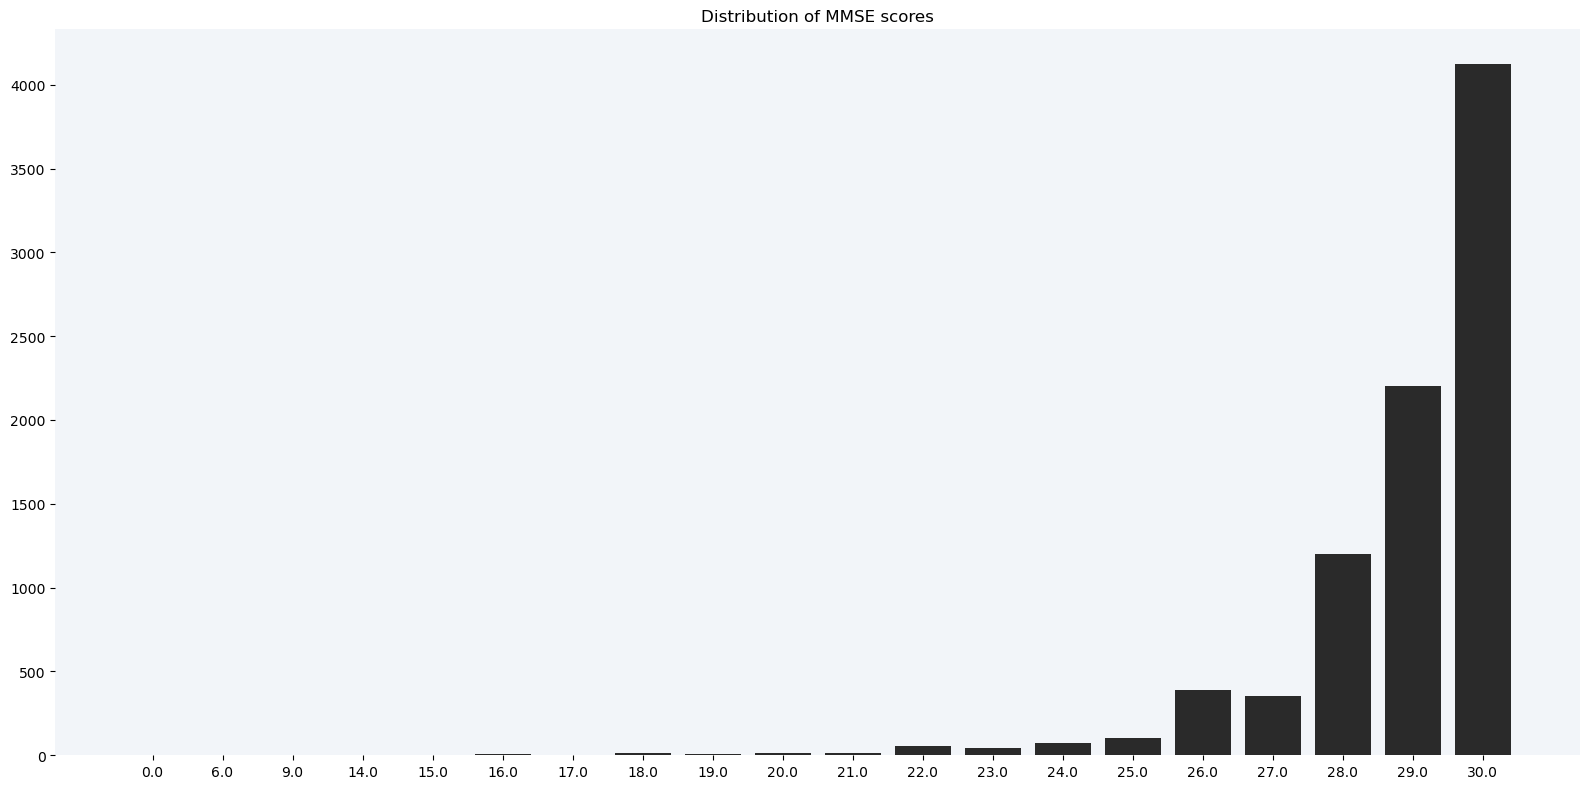

In [22]:
moca_df["MMSETOT"] = moca_df["MCATOT"].apply(utils.moca2mmse)

mmse = moca_df.groupby(["MMSETOT"]).size()

plt.bar(mmse.index.astype(str), mmse.values, color=color)
plt.title("Distribution of MMSE scores");

### Geriatric Depression Scale (GDS)

The original study used the GDS long form to calculate the GDS scores. However, GDS short form is only available in  PPMI. Therefore, the GDS scores will be out of 15 instead of 30. With this, we obtain the following distribution of GDS scores:

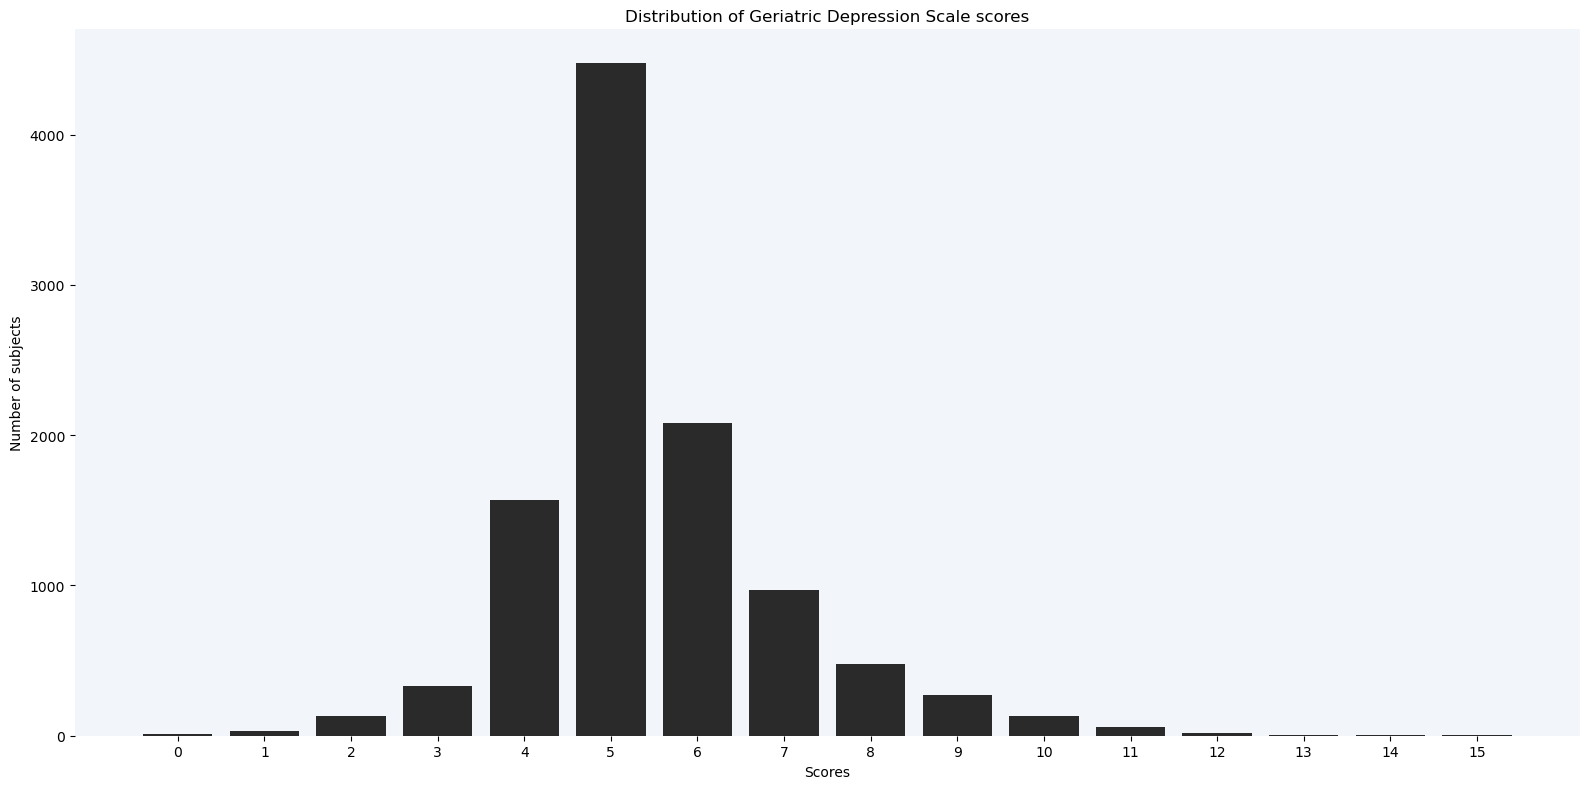

In [23]:
gdsshort_df = pd.read_csv(os.path.join(inputs_dir,"Geriatric_Depression_Scale__Short_Version_.csv"))
gdsshort_df = gdsshort_df.drop(["REC_ID","PAG_NAME", "INFODT","ORIG_ENTRY","LAST_UPDATE"], axis=1)

# Calculate GDS score for each patients
gds = gdsshort_df.iloc[:, 2:]
gds = gds.agg(['sum'], axis="columns").rename(columns={"sum": "GDSTOT"})

# Add gds score for each patients to DF
gdsshort_df = pd.concat([gdsshort_df[['PATNO', 'EVENT_ID']], gds], axis=1)

gds = gdsshort_df.groupby(["GDSTOT"]).size()

plt.bar(gds.index.astype(int).astype(str), gds.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Scores")
plt.title("Distribution of Geriatric Depression Scale scores");

### MRI Availabilty

So far we have gathered both demographics and clinical characteristics from the PPMI dataset, we need to make sure that there are enough MRI available to replicate the study. To check this, we will get the distribution of events based on MRI availability.

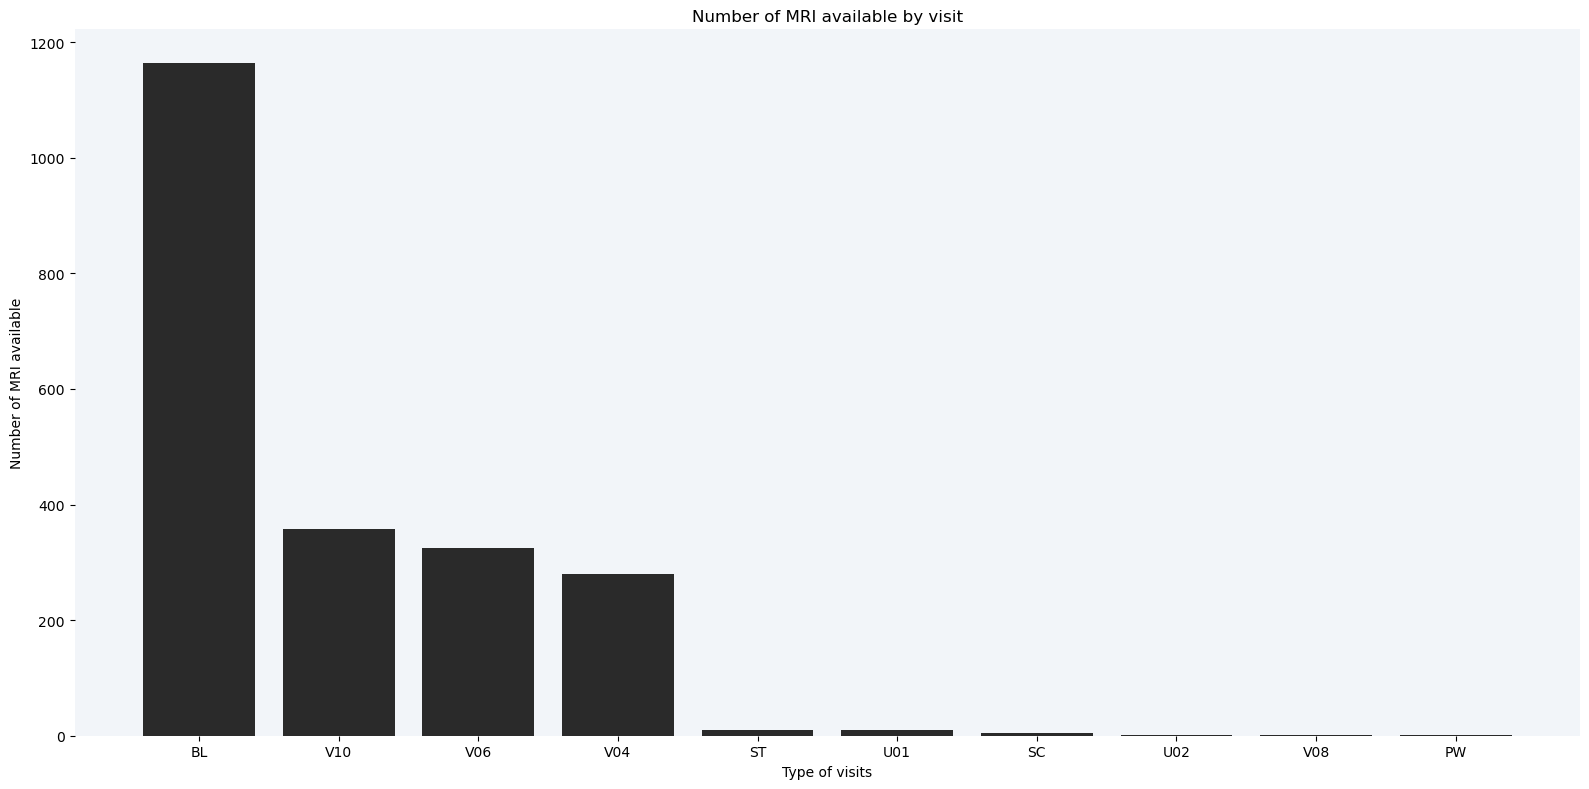

In [24]:
mri = pd.read_csv(os.path.join(data_dir,"MRI_info.csv"))
mri["EVENT_ID"] = mri["Visit code"]
mri["PATNO"] = mri["Subject ID"]
mri["Sex"] = mri["Sex"].map({"F": 0, "M": 1})
mri = mri.drop(
    ["Subject ID", "Visit code", "Visit", "Age", "Sex", "Description"], axis=1
)
mri_events = mri.groupby("EVENT_ID").size().sort_values(ascending=False)

plt.bar(mri_events.index, mri_events.values, color=color)
plt.ylabel("Number of MRI available")
plt.xlabel("Type of visits")
plt.title("Number of MRI available by visit");

As we can see in the graph above, BL (baseline), V10, V06 and V04 are the most frequent. Hence, we will only consider MRI with those visits.

### Data aggregation

Now that we have prepared all of our data, we will combine them into two respective dataframes, one for PD subjects and one for healthy controls.

Below is a summary of the number of subjects collected:

In [25]:
keys = ["PATNO", "EVENT_ID"]
pd_df = (
    cohort_def[cohort_def["COHORT"] == 1].merge(mri)
    .merge(cogstate_df, on=keys)
    .merge(age_df, on=keys)
    .merge(demo_df, on=["PATNO"])
    .merge(socioecon_df, on=["PATNO"])
    .merge(updrs3_df, on=keys)
    .merge(moca_df, on=keys)
    .merge(pdxdur_df, on=keys)
    .merge(ledd_df, on=["PATNO"])
    .merge(gdsshort_df, on=keys)
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda g: g["EVENT_ID"].nunique() > 1)
)

hc_df = (
    cohort_def[cohort_def["COHORT"] == 2].merge(mri)
    .merge(age_df, on=keys)
    .merge(demo_df, on=["PATNO"])
    .merge(socioecon_df, on=["PATNO"])
    .merge(moca_df, on=keys)
    .merge(gdsshort_df, on=keys)
    .drop_duplicates()
)

nc_patno = pd_df[pd_df["COGSTATE"] == 1]["PATNO"]
mci_patno = pd_df[pd_df["COGSTATE"] == 2]["PATNO"]

In [26]:
print(f"Unique number of HC patients: {hc_df['PATNO'].nunique()}")
print(f"Unique number of NC patients: {nc_patno.nunique()}")
print(f"Unique number of MCI patients: {mci_patno.nunique()}")

Unique number of HC patients: 171
Unique number of NC patients: 140
Unique number of MCI patients: 46


### Acceptable visit pairs

To be able to replicate our cohort, we need subjects with follow-up scans. The original study followed up each subjects for 18 months. Below we will find the number of unique PD-MCI, PD-NC and HC subjects per visit pairs.

In [27]:
maketal.find_acceptable_visit_pairs(pd_df,hc_df)

Unique PD-MCI subjects per visit pairs:
BL  & V04 =   2 | Month difference:                 12
BL  & V06 =   3 | Month difference:                 24
BL  & V10 =   3 | Month difference:                 48
V04 & V06 =  12 | Month difference:                 12
V04 & V10 =   9 | Month difference:                 36
V06 & V10 =  17 | Month difference:                 24

Unique PD-NC subjects per visit pairs:
BL  & V04 =  30 | Month difference:                 12
BL  & V06 =  42 | Month difference:                 24
BL  & V10 =  33 | Month difference:                 48
V04 & V06 =  72 | Month difference:                 12
V04 & V10 =  63 | Month difference:                 36
V06 & V10 =  83 | Month difference:                 24

Unique HC subjects per visit pairs:
BL  & V04 =  63 | Month difference:                 12
BL  & V06 =   9 | Month difference:                 24
BL  & V08 =   2 | Month difference:                 36
BL  & V10 =  12 | Month difference:                 48
V04

Since the number of MCI subjects is quite low, we will focus on the pairs of visit that has the most number of MCI subjects, i.e, we will use a time interval of 12 and 24 months to replicate our cohort.

Now that the number of the months between baseline and follow-up is determined, we can now proceed to cohort matching.

## Cohort Summary

In [28]:
def cohort_summary(*, hc, nc, mci, title):
    def gen_row(D, *, agg, col, f="4.1f", sep=" ± "):
        if not isinstance(agg, str) and isinstance(agg, Iterable):
            return [f"{sep}".join([f"{d.loc[a][col]:{f}}" for a in agg]) for d in D]
        else:
            return [f"{d.loc[agg][col]:{f}}" for d in D]

    def gender_ratio(df):
        male_count = df[df["SEX"] == 1]["PATNO"].nunique()
        return f"{male_count:.0f}, {male_count / df['PATNO'].nunique() * 100:.1f}%"

    D = [hc.describe(), nc.describe(), mci.describe()]

    table = Table(title=title, box=rich.box.HORIZONTALS, show_footer=True, expand=True,
                  style="#cfd5e4", row_styles=["on #f2f5f9", ""])

    table.add_column( footer="Values expressed as mean ± SD.")
    table.add_column("Healthy Controls")
    table.add_column("PD-NC")
    table.add_column("PD-MCI")
#     table.add_column("[italic]P[not italic]-value")  # TODO
    
    table.add_row("n", *gen_row(D, agg="count", col="PATNO", f=".0f"))
    table.add_row("Age (y)", *gen_row(D, agg=["mean", "std"], col="AGE_AT_VISIT"))
    table.add_row(
        "Age range", *gen_row(D, agg=["min", "max"], col="AGE_AT_VISIT", sep=" - ")
    )
    table.add_row(
        "Gender (male, %)", gender_ratio(hc), gender_ratio(nc), gender_ratio(mci)
    )
    table.add_row("Education (y)", *gen_row(D, agg=["mean", "std"], col="EDUCYRS"))
    table.add_row(
        "Disease duration (mo)", "", *gen_row(D[1:], agg=["mean", "std"], col="PDXDUR")
    )
    table.add_row("LEDD (mg/d) baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="LEDD"))
    table.add_row("LEDD (mg/d) follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="LEDD_NX"))
    table.add_row("H&Y baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY"))
    table.add_row("H&Y follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY_NX"))
    table.add_row("UPDRS III baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT"))
    table.add_row(
        "UPDRS III follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT_NX")
    )
    table.add_row("MMSE baseline", *gen_row(D, agg=["mean", "std"], col="MMSETOT"))
    table.add_row("MMSE follow-up", *gen_row(D, agg=["mean", "std"], col="MMSETOT_NX"))
    table.add_row("MoCA baseline", *gen_row(D, agg=["mean", "std"], col="MCATOT"))
    table.add_row("MoCA follow-up", *gen_row(D, agg=["mean", "std"], col="MCATOT_NX"))
    table.add_row("GDS baseline", *gen_row(D, agg=["mean", "std"], col="GDSTOT"))
    table.add_row("GDS follow-up", *gen_row(D, agg=["mean", "std"], col="GDSTOT_NX"))

    console = Console()
    console.print(table)

### Cohort with follow-up after 12 months

In [29]:
mci, nc, hc = maketal.create_cohort(pd_df=pd_df, hc_df=hc_df, months=12)

print(
    f"""Unique number of:
  - HC subjects:     {hc['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  64 (/66)
  - PD-MCI subjects: 13 (/39)



With a follow-up of 12 months, more than 60% of PD-MCI subjects are missing. 

In [30]:
cohort_summary(
    hc=hc,
    nc=nc,
    mci=mci,
    title="Demographic and clinical characteristics\n(12 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                               (12 months follow-up)                                               
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            37                        64                    13                  
  Age (y)                                      59.6 ± 11.9               61.0 ±  8.9           65.3 ±  8.5         
  Age range                                    30.6 - 79.8               38.5 - 78.3           50.4 - 72.7         
  Gender (male, %)                             24, 64.9%                 39, 60.9%             9, 69.2%            
  Education (y)                                15.7 ±  3.1               15.0 ±  2.9           15.1 ±  2.9         
  Disease duration (mo)                                                   3.9 ±  2.6            4.8 ±  4.0         
  LEDD (mg/d) baseline                                                   264.6 ± 250.2         240.9 ± 206.9       
  LEDD (mg/d) follow-up                                                  264.6 ± 250.2         240.9 ± 206.9       
  H&Y baseline                                                            1.7 ±  0.6            1.8 ±  0.6         
  H&Y follow-up                                                           1.8 ±  0.5            1.7 ±  0.5         
  UPDRS III baseline                                                     19.6 ±  8.8           21.0 ± 12.2         
  UPDRS III follow-up                                                    21.3 ±  9.8           25.3 ± 12.8         
  MMSE baseline                                29.7 ±  0.5               29.3 ±  1.0           28.2 ±  1.1         
  MMSE follow-up                               29.4 ±  0.9               29.3 ±  1.0           28.4 ±  1.4         
  MoCA baseline                                28.4 ±  1.1               27.4 ±  2.1           25.1 ±  2.3         
  MoCA follow-up                               27.6 ±  2.1               27.4 ±  2.2           25.6 ±  2.8         
  GDS baseline                                  5.2 ±  1.3                5.3 ±  1.4            5.5 ±  1.2         
  GDS follow-up                                 4.9 ±  1.5                5.3 ±  1.7            5.6 ±  1.7         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

### Cohort with follow-up after 24 months

In [31]:
mci_, nc_, hc_ = maketal.create_cohort(pd_df=pd_df, hc_df=hc_df, months=24)

print(
    f"""Unique number of:
  - HC subjects:     {hc_['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci_['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     9 (/37)
  - PD-NC subjects:  64 (/66)
  - PD-MCI subjects: 19 (/39)



With a follow-up of 24 months, 75% of Healthy Controls and more than 50% of PD-MCI subjects are missing.

In [32]:
cohort_summary(
    hc=hc_,
    nc=nc_,
    mci=mci_,
    title="Demographic and clinical characteristics\n(24 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                               (24 months follow-up)                                               
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            9                         64                    19                  
  Age (y)                                      54.6 ± 15.5               62.1 ±  8.8           66.1 ±  8.6         
  Age range                                    30.6 - 76.8               41.2 - 75.2           49.9 - 79.2         
  Gender (male, %)                             6, 66.7%                  40, 62.5%             16, 84.2%           
  Education (y)                                14.2 ±  4.3               15.5 ±  3.1           15.1 ±  3.1         
  Disease duration (mo)                                                   4.4 ±  2.9            5.1 ±  3.1         
  LEDD (mg/d) baseline                                                   251.0 ± 219.2         297.4 ± 287.2       
  LEDD (mg/d) follow-up                                                  251.0 ± 219.2         297.4 ± 287.2       
  H&Y baseline                                                            1.7 ±  0.5            1.9 ±  0.2         
  H&Y follow-up                                                           1.9 ±  0.6            2.1 ±  0.7         
  UPDRS III baseline                                                     23.1 ± 11.0           26.7 ± 10.2         
  UPDRS III follow-up                                                    25.8 ± 13.9           28.4 ± 12.2         
  MMSE baseline                                29.8 ±  0.4               29.3 ±  1.1           28.5 ±  0.7         
  MMSE follow-up                               29.8 ±  0.4               29.3 ±  1.0           28.3 ±  1.4         
  MoCA baseline                                29.0 ±  1.2               27.4 ±  2.2           25.6 ±  1.6         
  MoCA follow-up                               28.7 ±  1.1               27.4 ±  2.2           25.3 ±  2.6         
  GDS baseline                                  5.1 ±  0.6                5.4 ±  1.5            6.1 ±  1.9         
  GDS follow-up                                 5.0 ±  0.5                5.1 ±  1.0            6.0 ±  1.7         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

### Cohort follow up after both 12 and 24 months

Since the two previous cohorts are no where near the original paper's cohort, we will try to merge subjects with both a follow-up of 12 and 24 months in one cohort.

In [33]:
# Merging PD-MCI
mci_mix = pd.concat([mci, mci_])
mci_mix = mci_mix.sample(frac=1, random_state=42)
mci_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Merging PD-NC
nc_mix = pd.concat([nc, nc_])
nc_mix = nc_mix.sample(frac=1, random_state=42)
nc_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Merging HC subjecs
hc_mix = pd.concat([hc, hc_])
hc_mix = hc_mix.sample(frac=1, random_state=42)
hc_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Removing subjects that appears in more than one group
pd_mix = pd.concat([mci_mix, nc_mix])
duplicates = pd_mix[pd_mix.duplicated(['PATNO'])].index
nc_mix.drop(index=duplicates, inplace=True)

hc_mix = hc_mix.head(37)
nc_mix = nc_mix.head(66)

print(
    f"""Unique number of:
  - HC subjects:     {hc_mix['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_mix['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci_mix['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  66 (/66)
  - PD-MCI subjects: 28 (/39)



By doing so, we were able to collect more than 70% of PD-MCI subjects. This is by far the closest we can get to the original cohort.

In [34]:
cohort_summary(
    hc=hc_mix,
    nc=nc_mix,
    mci=mci_mix,
    title="Demographic and clinical characteristics\n(12 & 24 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                            (12 & 24 months follow-up)                                             
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            37                        66                    28                  
  Age (y)                                      60.2 ± 11.9               61.5 ±  9.0           65.2 ±  8.8         
  Age range                                    30.6 - 79.8               38.5 - 78.3           49.9 - 79.2         
  Gender (male, %)                             25, 67.6%                 45, 68.2%             21, 75.0%           
  Education (y)                                16.0 ±  3.2               15.8 ±  2.8           15.2 ±  2.9         
  Disease duration (mo)                                                   4.5 ±  2.8            4.6 ±  3.4         
  LEDD (mg/d) baseline                                                   256.9 ± 239.1         285.4 ± 263.0       
  LEDD (mg/d) follow-up                                                  256.9 ± 239.1         285.4 ± 263.0       
  H&Y baseline                                                            1.7 ±  0.6            1.9 ±  0.4         
  H&Y follow-up                                                           1.8 ±  0.5            2.0 ±  0.6         
  UPDRS III baseline                                                     22.1 ± 11.0           24.1 ± 11.1         
  UPDRS III follow-up                                                    23.3 ± 11.6           27.2 ± 12.3         
  MMSE baseline                                29.6 ±  0.5               29.3 ±  1.0           28.3 ±  0.9         
  MMSE follow-up                               29.4 ±  0.9               29.3 ±  0.9           28.6 ±  1.3         
  MoCA baseline                                28.3 ±  1.2               27.5 ±  2.1           25.2 ±  2.0         
  MoCA follow-up                               27.6 ±  2.1               27.6 ±  2.1           25.8 ±  2.4         
  GDS baseline                                  5.2 ±  1.3                5.4 ±  1.6            5.8 ±  1.7         
  GDS follow-up                                 4.9 ±  1.5                5.2 ±  1.4            6.0 ±  1.7         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

## Image Pre-Processing

The initial processing of T1 MRI images, for each subject and each time point (baseline and follow-up), includes the following steps: 
- removal of non-brain tissue (skull stripping)
- automated Talairach transformation (atlas) 
- segmentation of the subcortical white matter and deep grey matter volumetric structures
- intensity normalization
- tessellation of the grey matter/white matter boundary
- automated topology correction and surface deformation to optimally place the grey matter/white matter and grey matter/CSF boundaries. 

The cortical thickness was calculated as the closest distance from the grey/white matter boundary to the grey/CSF boundary at each vertex.

### Subcortical Volumes 

|Session|EVENT_ID|
|:---|:---|
|1 | Baseline |
|5 | Month 12|
|7| Month 24|
|11|Month 48|

Subcortical segmentations: thalamus, caudate, putamen, pallidum, hippocampus, amygdala, and the nucleus accumbens

In [35]:
structName = ['Thalamus-Proper', 'Caudate', 'Putamen', 'Pallidum', 'Hippocampus', 'Amygdala', 'Accumbens-area']

Item = namedtuple('Item', ['PATNO', 'COGSTATE', 'Age', 'Sex', 'Education', 'Hemisphere','StructName', 'Volumes', 'TIVs'])

visit = ['initial','follow-up']


def visits(sub_id, visit):
    return list(product(sub_id, visit))


def subcortical_volume(sub_id, cogstate, df):
    
    def find_item(sub_id, struct):
        for i in items:
            if i.PATNO == sub_id and (i.Hemisphere +'-'+ i.StructName) == struct:
                return i 

    items = [] 
    
    lines = []
    
    event = visits(sub_id, visit)

    for i in event:
        freesurfer_dir = 'freesurfer/' + cogstate + '/' + i[1] 
        try:
            with open(os.path.join(freesurfer_dir, "aseg-" + str(i[0]) + ".stats")) as f:
                lines = f.readlines()
                
                if cogstate == "hc":
                    cog = 0
                else:
                    cog = df.loc[df.PATNO==i[0], 'COGSTATE'].values[0]
                    
                tiv = lines[34].strip().split(',')[-2]
                age = df.loc[df.PATNO==i[0], 'AGE_AT_VISIT'].values[0]
                sex = df.loc[df.PATNO==i[0], 'SEX'].values[0]
                educ = df.loc[df.PATNO==i[0], 'EDUCYRS'].values[0]
                for line in lines[80:]:
                    line = line.strip().split()           
                    name = line[4]
                    volume = line[3]
                    if i[1] == "follow-up":
                        init = find_item(i[0], name)
                        if init is not None:
                            init.Volumes.append(volume)
                            init.TIVs.append(tiv)
                    else:        
                        if 'Left' in name:
                            items.append(Item(i[0], cog, age, sex, educ, 'Left', name[5:], [volume], [tiv]))
                        elif 'Right' in name:
                            items.append(Item(i[0], cog, age, sex, educ, 'Right', name[6:], [volume], [tiv]))
        except:
            print(os.path.join(freesurfer_dir, "aseg-" + str(i[0]) + ".stats") + " not found")

    subcortical_seg = pd.DataFrame.from_records(items, columns=['PATNO', 'COGSTATE', 'AGE', 'SEX', 'EDUCYRS', 'HEM', 'STRUCT', 'VOLS', 'TIVS'])
    subcortical_seg = subcortical_seg[subcortical_seg["STRUCT"].isin(structName)]
    subcortical_seg.reset_index(inplace=True, drop=True)

    vol = pd.DataFrame(subcortical_seg['VOLS'].to_list(), columns=['VOL','VOL_NX'])
    tiv = pd.DataFrame(subcortical_seg['TIVS'].to_list(), columns=['TIV','TIV_NX'])

    subcortical_seg = pd.concat([subcortical_seg, vol], axis=1) 
    subcortical_seg.drop(columns=['VOLS'], inplace=True)
    
    subcortical_seg = pd.concat([subcortical_seg, tiv], axis=1) 
    subcortical_seg.drop(columns=['TIVS'], inplace=True)

    subcortical_seg['VOL'] = subcortical_seg['VOL'].map(lambda x: float(x)/1000)
    subcortical_seg['VOL_NX'] = subcortical_seg['VOL_NX'].map(lambda x: float(x)/1000)
    
    subcortical_seg['TIV'] = subcortical_seg['TIV'].map(lambda x: float(x)/1000)
    subcortical_seg['TIV_NX'] = subcortical_seg['TIV_NX'].map(lambda x: float(x)/1000)

    subcortical_seg['% CHANGE'] = round(((subcortical_seg['VOL_NX'] - subcortical_seg['VOL']) 
                                            / subcortical_seg['VOL']) * 100, 1)
    return subcortical_seg

In [36]:
def compare_subcortical_volume(hc_vol_df, nc_vol_df, mci_vol_df):
    # Healthy controls
    hc_vol_df = hc_vol_df.groupby(['HEM', 'STRUCT'], sort=False).agg({'VOL': np.mean, '% CHANGE': np.mean})
    hc_cols = pd.MultiIndex.from_tuples([("Healthy Controls", "VOL"),
                                      ("Healthy Controls", "% CHANGE")])
    hc_vol_df.columns = hc_cols
    
    # PD-NC
    nc_vol_df = nc_vol_df.groupby(['HEM', 'STRUCT'], sort=False).agg({'VOL': np.mean,'% CHANGE': np.mean})
    nc_cols = pd.MultiIndex.from_tuples([("PD-NC", "VOL"), 
                                      ("PD-NC", "% CHANGE")])
    nc_vol_df.columns = nc_cols
    
    # PD-MCI
    mci_vol_df = mci_vol_df.groupby(['HEM', 'STRUCT'], sort=False).agg({'VOL': np.mean,'% CHANGE': np.mean})
    mci_cols = pd.MultiIndex.from_tuples([("PD-MCI", "VOL"), 
                                      ("PD-MCI", "% CHANGE")])
    mci_vol_df.columns = mci_cols
    
    # merge all three df together
    return hc_vol_df.join(nc_vol_df).join(mci_vol_df)

In [42]:
def ancova_and_post_hoc(df1, df2, df3, struct, hem):
    df1 = df1.loc[(hc_vol['STRUCT'] == struct) & (hc_vol['HEM'] == hem)]
    df2 = df2.loc[(nc_vol['STRUCT'] == struct) & (nc_vol['HEM'] == hem)]
    df3 = df3.loc[(mci_vol['STRUCT'] == struct) & (mci_vol['HEM'] == hem)]

    frames = [df1, df2, df3]

    result = pd.concat(frames)
    
    print(hem, struct)
    
    print(ancova(data=result, dv='% CHANGE', covar=['AGE', 'SEX', 'EDUCYRS','TIV','TIV_NX'], between='COGSTATE'), "\n")
    
    tukey = pairwise_tukeyhsd(endog=result['% CHANGE'],
                          groups=result['COGSTATE'],
                          alpha=0.05)
   
    print(tukey, "\n")
    
    return 

def ancova_and_post_hoc_baseline_vol(df1, df2, df3, struct, hem):
    df1 = df1.loc[(hc_vol['STRUCT'] == struct) & (hc_vol['HEM'] == hem)]
    df2 = df2.loc[(nc_vol['STRUCT'] == struct) & (nc_vol['HEM'] == hem)]
    df3 = df3.loc[(mci_vol['STRUCT'] == struct) & (mci_vol['HEM'] == hem)]

    frames = [df1, df2, df3]

    result = pd.concat(frames)
    
    print(hem, struct)
    
    print(ancova(data=result, dv='VOL', covar=['AGE', 'SEX', 'EDUCYRS','TIV','TIV_NX'], between='COGSTATE'), "\n")
    
    tukey = pairwise_tukeyhsd(endog=result['VOL'],
                          groups=result['COGSTATE'],
                          alpha=0.05)
   
    print(tukey, "\n")
    
    return 

def ancova_and_post_hoc_followup_vol(df1, df2, df3, struct, hem):
    df1 = df1.loc[(hc_vol['STRUCT'] == struct) & (hc_vol['HEM'] == hem)]
    df2 = df2.loc[(nc_vol['STRUCT'] == struct) & (nc_vol['HEM'] == hem)]
    df3 = df3.loc[(mci_vol['STRUCT'] == struct) & (mci_vol['HEM'] == hem)]

    frames = [df1, df2, df3]

    result = pd.concat(frames)
    
    print(hem, struct)
    
    print(ancova(data=result, dv='VOL_NX', covar=['AGE', 'SEX', 'EDUCYRS','TIV','TIV_NX'], between='COGSTATE'), "\n")
    
    tukey = pairwise_tukeyhsd(endog=result['VOL_NX'],
                          groups=result['COGSTATE'],
                          alpha=0.05)
   
    print(tukey, "\n")
    
    return 

In [38]:
hc_vol = subcortical_volume(hc_mix['PATNO'].to_list(), "hc", hc_mix)
nc_vol = subcortical_volume(nc_mix['PATNO'].to_list(), "pd-nc", nc_mix)
mci_vol = subcortical_volume(mci_mix['PATNO'].to_list()[:-2], "pd-mci", mci_mix)

% Change

In [43]:
for s in structName:
    ancova_and_post_hoc(hc_vol, nc_vol, mci_vol, s, "Left")
    ancova_and_post_hoc(hc_vol, nc_vol, mci_vol, s, "Right")

Left Thalamus-Proper
     Source           SS   DF         F     p-unc       np2
0  COGSTATE    40.737711    2  0.968272  0.382661  0.015752
1       AGE    23.340556    1  1.109538  0.294281  0.009086
2       SEX    16.967958    1  0.806604  0.370910  0.006622
3   EDUCYRS    10.269751    1  0.488192  0.486076  0.004018
4       TIV     6.503359    1  0.309150  0.579229  0.002548
5    TIV_NX     1.926925    1  0.091600  0.762672  0.000756
6  Residual  2545.390417  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.8862 0.6122 -1.3352 3.1075  False
   0.0    2.0  -0.1339 0.9928 -2.9019 2.6341  False
   1.0    2.0    -1.02 0.5997 -3.5245 1.4844  False
--------------------------------------------------- 

Right Thalamus-Proper
     Source           SS   DF         F     p-unc       np2
0  COGSTATE   166.172615    2  2.535183  0.083450  0.040219
1       AGE    24.992036    1  0.762573  0.384254  0.006263
2       SEX    13.861773    1  0.422959  0.516697  0.003483
3   EDUCYRS    29.300475    1  0.894035  0.346271  0.007335
4       TIV     6.538031    1  0.199493  0.655929  0.001646
5    TIV_NX    15.844802    1  0.483467  0.488189  0.003980
6  Residual  3965.569266  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   2.1686 0.1562 -0.6042 4.9415  False
   0.0    2.0   0.6146 0.9066 -2.8405 4.0696  False
   1.0    2.0  -1.5541 0.4679 -4.6802 1.5721  False
--------------------------------------------------- 

Left Caudate
     Source           SS   DF         F     p-unc       np2
0  COGSTATE     5.067956    2  0.162074  0.850563  0.002672
1       AGE    17.179415    1  1.098797  0.296619  0.008999
2       SEX    44.529386    1  2.848105  0.094058  0.022997
3   EDUCYRS     5.579954    1  0.356894  0.551352  0.002941
4       TIV   101.171402    1  6.470934  0.012225  0.050764
5    TIV_NX   121.947071    1  7.799749  0.006076  0.060557
6  Residual  1891.803975  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.2441 0.9542 -1.7413 2.2295  False
   0.0    2.0  -0.3283 0.9469 -2.8022 2.1456  False
   1.0    2.0  -0.5724 0.8168 -2.8108  1.666  False
--------------------------------------------------- 

Right Caudate
     Source           SS   DF          F     p-unc       np2
0  COGSTATE    63.872977    2   1.161089  0.316609  0.018830
1       AGE    64.706035    1   2.352465  0.127696  0.019071
2       SEX     1.049095    1   0.038141  0.845488  0.000315
3   EDUCYRS     2.613310    1   0.095010  0.758432  0.000785
4       TIV   339.415622    1  12.339860  0.000624  0.092544
5    TIV_NX   338.431993    1  12.304099  0.000635  0.092301
6  Residual  3328.181237  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.6101 0.8497 -2.0499 3.2701  False
   0.0    2.0  -1.3729 0.5893 -4.6874 1.9416  False
   1.0    2.0   -1.983 0.2632  -4.982  1.016  False
--------------------------------------------------- 

Left Putamen
     Source           SS   DF         F     p-unc       np2
0  COGSTATE     9.745468    2  0.111306  0.894757  0.001836
1       AGE     0.041966    1  0.000959  0.975351  0.000008
2       SEX   118.288379    1  2.702012  0.102818  0.021843
3   EDUCYRS     3.422350    1  0.078175  0.780263  0.000646
4       TIV    54.485482    1  1.244589  0.266799  0.010181
5    TIV_NX    44.480272    1  1.016044  0.315471  0.008327
6  Residual  5297.124225  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.6905 0.8704 -3.9514 2.5703  False
   0.0    2.0  -0.4867 0.9565 -4.5499 3.5765  False
   1.0    2.0   0.2038 0.9905 -3.4725 3.8802  False
--------------------------------------------------- 

Right Putamen
     Source           SS   DF         F     p-unc           np2
0  COGSTATE    17.975944    2  0.134147  0.874592  2.212395e-03
1       AGE     3.263823    1  0.048713  0.825690  4.024246e-04
2       SEX   178.524281    1  2.664498  0.105210  2.154619e-02
3   EDUCYRS     9.755929    1  0.145609  0.703437  1.201930e-03
4       TIV     0.003125    1  0.000047  0.994562  3.854834e-07
5    TIV_NX     0.429074    1  0.006404  0.936350  5.292267e-05
6  Residual  8107.131770  121       NaN       NaN           NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0018    1.0 -4.0043 4.0008  False
   0.0    2.0  -1.2691 0.8185 -6.2566 3.7183  False
   1.0    2.0  -1.2674 0.7836   -5.78 3.2453  False
--------------------------------------------------- 

Left Pallidum
     Source           SS   DF         F     p-unc       np2
0  COGSTATE    84.070067    2  0.778811  0.461238  0.012709
1       AGE     0.071576    1  0.001326  0.971011  0.000011
2       SEX    10.894111    1  0.201842  0.654041  0.001665
3   EDUCYRS     0.013965    1  0.000259  0.987193  0.000002
4       TIV     0.016808    1  0.000311  0.985950  0.000003
5    TIV_NX     0.115595    1  0.002142  0.963164  0.000018
6  Residual  6530.772922  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   1.2429 0.6795 -2.2705 4.7562  False
   0.0    2.0  -0.7508 0.9129 -5.1286  3.627  False
   1.0    2.0  -1.9937 0.4591 -5.9547 1.9673  False
--------------------------------------------------- 

Right Pallidum
     Source           SS   DF         F     p-unc       np2
0  COGSTATE    46.422516    2  0.433060  0.649523  0.007107
1       AGE    43.552915    1  0.812580  0.369149  0.006671
2       SEX     3.279934    1  0.061195  0.805037  0.000505
3   EDUCYRS     1.204347    1  0.022470  0.881093  0.000186
4       TIV    97.679171    1  1.822430  0.179544  0.014838
5    TIV_NX    88.172238    1  1.645056  0.202085  0.013413
6  Residual  6485.395595  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   1.3297 0.6471 -2.2106 4.8701  False
   0.0    2.0   0.4797  0.964 -3.9318 4.8912  False
   1.0    2.0    -0.85  0.869 -4.8415 3.1415  False
--------------------------------------------------- 

Left Hippocampus
     Source           SS   DF         F     p-unc       np2
0  COGSTATE     1.540129    2  0.058052  0.943627  0.000959
1       AGE    12.825132    1  0.966837  0.327432  0.007927
2       SEX    29.533713    1  2.226432  0.138270  0.018068
3   EDUCYRS     1.419634    1  0.107021  0.744127  0.000884
4       TIV    37.186541    1  2.803349  0.096651  0.022644
5    TIV_NX    34.247086    1  2.581755  0.110708  0.020891
6  Residual  1605.070203  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1702 0.9728  -1.634 1.9745  False
   0.0    2.0  -0.4957 0.8603  -2.744 1.7525  False
   1.0    2.0   -0.666 0.7181 -2.7002 1.3682  False
--------------------------------------------------- 

Right Hippocampus
     Source           SS   DF         F     p-unc       np2
0  COGSTATE     5.696703    2  0.220542  0.802406  0.003632
1       AGE    69.009484    1  5.343265  0.022494  0.042292
2       SEX     9.988127    1  0.773361  0.380923  0.006351
3   EDUCYRS    12.452400    1  0.964164  0.328099  0.007905
4       TIV    25.486065    1  1.973335  0.162656  0.016047
5    TIV_NX    16.798869    1  1.300703  0.256337  0.010635
6  Residual  1562.742469  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.6123 0.6936 -2.3912 1.1666  False
   0.0    2.0  -1.4256 0.2825 -3.6422  0.791  False
   1.0    2.0  -0.8133 0.6023 -2.8188 1.1923  False
--------------------------------------------------- 

Left Amygdala
     Source           SS   DF         F     p-unc       np2
0  COGSTATE   129.613820    2  0.942388  0.392537  0.015338
1       AGE   251.429107    1  3.656149  0.058227  0.029330
2       SEX     5.319366    1  0.077351  0.781394  0.000639
3   EDUCYRS     8.663025    1  0.125973  0.723262  0.001040
4       TIV    79.289667    1  1.152988  0.285061  0.009439
5    TIV_NX    52.358288    1  0.761367  0.384629  0.006253
6  Residual  8321.028602  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.9131 0.8549 -3.1445 4.9708  False
   0.0    2.0   1.6656 0.7152 -3.3904 6.7216  False
   1.0    2.0   0.7524 0.9196 -3.8222 5.3271  False
--------------------------------------------------- 

Right Amygdala
     Source           SS   DF         F     p-unc       np2
0  COGSTATE     6.493308    2  0.045800  0.955249  0.000756
1       AGE   113.149009    1  1.596181  0.208874  0.013020
2       SEX     5.698028    1  0.080381  0.777266  0.000664
3   EDUCYRS    78.527628    1  1.107781  0.294662  0.009072
4       TIV   142.777910    1  2.014153  0.158409  0.016373
5    TIV_NX    91.464842    1  1.290285  0.258240  0.010551
6  Residual  8577.365363  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.552 0.9462 -3.5826 4.6866  False
   0.0    2.0   0.0889 0.9991 -5.0631 5.2408  False
   1.0    2.0  -0.4632 0.9699 -5.1246 4.1983  False
--------------------------------------------------- 

Left Accumbens-area
     Source            SS   DF         F     p-unc       np2
0  COGSTATE    436.188846    2  1.415427  0.246813  0.022861
1       AGE     59.442152    1  0.385778  0.535695  0.003178
2       SEX     42.344145    1  0.274812  0.601081  0.002266
3   EDUCYRS      1.453107    1  0.009431  0.922799  0.000078
4       TIV     62.151923    1  0.403364  0.526556  0.003323
5    TIV_NX     42.610829    1  0.276543  0.599938  0.002280
6  Residual  18644.144928  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   2.7809 0.5136  -3.1951 8.7569  False
   0.0    2.0  -1.9483 0.8091  -9.3948 5.4981  False
   1.0    2.0  -4.7293 0.2228 -11.4668 2.0083  False
---------------------------------------------------- 

Right Accumbens-area
     Source            SS   DF         F     p-unc       np2
0  COGSTATE    109.475615    2  0.518344  0.596822  0.008495
1       AGE      0.758360    1  0.007181  0.932606  0.000059
2       SEX     94.078774    1  0.890886  0.347118  0.007309
3   EDUCYRS    214.979420    1  2.035763  0.156212  0.016546
4       TIV      9.061631    1  0.085810  0.770075  0.000709
5    TIV_NX      1.176336    1  0.011139  0.916119  0.000092
6  Residual  12777.770505  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -1.1183 0.8549 -6.0878 3.8511  False
   0.0    2.0   -1.714  0.789 -7.9063 4.4782  False
   1.0    2.0  -0.5957 0.9656 -6.1984 5.0071  False
--------------------------------------------------- 



VOL

In [44]:
for s in structName:
    ancova_and_post_hoc_baseline_vol(hc_vol, nc_vol, mci_vol, s, "Left")
    ancova_and_post_hoc_baseline_vol(hc_vol, nc_vol, mci_vol, s, "Right")

Left Thalamus-Proper
     Source         SS   DF          F         p-unc       np2
0  COGSTATE   1.172084    2   2.131880  1.230483e-01  0.034038
1       AGE  22.706093    1  82.599267  2.388224e-15  0.405695
2       SEX   0.100674    1   0.366229  5.462004e-01  0.003018
3   EDUCYRS   0.207844    1   0.756085  3.862780e-01  0.006210
4       TIV   0.190189    1   0.691862  4.071702e-01  0.005685
5    TIV_NX   0.171268    1   0.623031  4.314672e-01  0.005123
6  Residual  33.262247  121        NaN           NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.4446 0.0171  0.0655 0.8237   True
   0.0    2.0   0.3092 0.2702 -0.1632 0.7816  False
   1.0    2.0  -0.1354 0.7335 -0.5628 0.2921  False
--------------------------------------------------- 

Right Thalamus-Proper
     Source         SS   DF          F         p-unc       np2
0  COGSTATE   0.336095    2   0.690161  5.034584e-01  0.011279
1       AGE  15.979763    1  65.628004  4.951372e-13  0.351651
2       SEX   0.074942    1   0.307784  5.800672e-01  0.002537
3   EDUCYRS   0.088523    1   0.363559  5.476650e-01  0.002996
4       TIV   0.295951    1   1.215453  2.724428e-01  0.009945
5    TIV_NX   0.152642    1   0.626890  4.300477e-01  0.005154
6  Residual  29.462290  121        NaN           NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.375 0.0445  0.0073 0.7427   True
   0.0    2.0   0.2769  0.327 -0.1813 0.7351  False
   1.0    2.0  -0.0981 0.8409 -0.5127 0.3165  False
--------------------------------------------------- 

Left Caudate
     Source         SS   DF         F     p-unc       np2
0  COGSTATE   0.352059    2  0.939630  0.393605  0.015294
1       AGE   0.735340    1  3.925179  0.049836  0.031420
2       SEX   0.013885    1  0.074118  0.785896  0.000612
3   EDUCYRS   0.533390    1  2.847189  0.094110  0.022990
4       TIV   0.053116    1  0.283526  0.595376  0.002338
5    TIV_NX   0.046326    1  0.247282  0.619898  0.002039
6  Residual  22.668053  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.081 0.7029 -0.1587 0.3207  False
   0.0    2.0   0.1776 0.3388 -0.1211 0.4763  False
   1.0    2.0   0.0966 0.6741 -0.1737 0.3669  False
--------------------------------------------------- 

Right Caudate
     Source         SS   DF         F     p-unc       np2
0  COGSTATE   0.465433    2  1.607408  0.204656  0.025881
1       AGE   0.761757    1  5.261574  0.023526  0.041672
2       SEX   0.237912    1  1.643297  0.202324  0.013399
3   EDUCYRS   0.505318    1  3.490307  0.064148  0.028037
4       TIV   0.075675    1  0.522701  0.471087  0.004301
5    TIV_NX   0.058283    1  0.402566  0.526965  0.003316
6  Residual  17.518076  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0796 0.6763  -0.144 0.3031  False
   0.0    2.0   0.1869 0.2531 -0.0917 0.4654  False
   1.0    2.0   0.1073 0.5719 -0.1447 0.3594  False
--------------------------------------------------- 

Left Putamen
     Source         SS   DF          F     p-unc       np2
0  COGSTATE   0.033000    2   0.067277  0.934971  0.001111
1       AGE   4.713436    1  19.218745  0.000025  0.137063
2       SEX   0.255202    1   1.040569  0.309724  0.008526
3   EDUCYRS   0.705809    1   2.877892  0.092375  0.023232
4       TIV   0.010160    1   0.041426  0.839060  0.000342
5    TIV_NX   0.107804    1   0.439566  0.508593  0.003620
6  Residual  29.675493  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1536 0.4047 -0.1293 0.4364  False
   0.0    2.0   0.0432 0.9545 -0.3092 0.3956  False
   1.0    2.0  -0.1104 0.6907 -0.4293 0.2085  False
--------------------------------------------------- 

Right Putamen
     Source         SS   DF          F     p-unc       np2
0  COGSTATE   0.057922    2   0.123540  0.883897  0.002038
1       AGE   3.689479    1  15.738530  0.000124  0.115099
2       SEX   0.379617    1   1.619364  0.205620  0.013206
3   EDUCYRS   0.459896    1   1.961818  0.163878  0.015955
4       TIV   0.226974    1   0.968224  0.327087  0.007938
5    TIV_NX   0.736958    1   3.143706  0.078737  0.025323
6  Residual  28.365226  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0645 0.8402 -0.2073 0.3363  False
   0.0    2.0   0.0022 0.9999 -0.3365 0.3408  False
   1.0    2.0  -0.0623 0.8798 -0.3687 0.2441  False
--------------------------------------------------- 

Left Pallidum
     Source        SS   DF         F     p-unc       np2
0  COGSTATE  0.279146    2  3.773870  0.025711  0.058715
1       AGE  0.327520    1  8.855700  0.003529  0.068196
2       SEX  0.052351    1  1.415505  0.236474  0.011563
3   EDUCYRS  0.196823    1  5.321836  0.022760  0.042129
4       TIV  0.000377    1  0.010207  0.919694  0.000084
5    TIV_NX  0.056980    1  1.540673  0.216919  0.012573
6  Residual  4.475068  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0763 0.2548 -0.0377 0.1902  False
   0.0    2.0   0.1631   0.02  0.0212 0.3051   True
   1.0    2.0   0.0869 0.2479 -0.0416 0.2153  False
--------------------------------------------------- 

Right Pallidum
     Source        SS   DF         F     p-unc       np2
0  COGSTATE  0.153873    2  1.989284  0.141242  0.031834
1       AGE  0.126326    1  3.266310  0.073201  0.026285
2       SEX  0.032508    1  0.840537  0.361067  0.006899
3   EDUCYRS  0.121746    1  3.147883  0.078541  0.025356
4       TIV  0.010493    1  0.271298  0.603414  0.002237
5    TIV_NX  0.118975    1  3.076230  0.081976  0.024793
6  Residual  4.679727  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0542 0.4903 -0.0584 0.1669  False
   0.0    2.0   0.1215  0.104 -0.0189 0.2619  False
   1.0    2.0   0.0673 0.4225 -0.0597 0.1943  False
--------------------------------------------------- 

Left Hippocampus
     Source         SS   DF          F     p-unc       np2
0  COGSTATE   0.286241    2   1.340529  0.265566  0.021677
1       AGE   2.070665    1  19.394750  0.000023  0.138144
2       SEX   0.135992    1   1.273761  0.261295  0.010417
3   EDUCYRS   0.000025    1   0.000234  0.987831  0.000002
4       TIV   0.014148    1   0.132518  0.716471  0.001094
5    TIV_NX   0.008870    1   0.083079  0.773660  0.000686
6  Residual  12.918467  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1375  0.168 -0.0419  0.317  False
   0.0    2.0  -0.0128 0.9899 -0.2364 0.2108  False
   1.0    2.0  -0.1503 0.1865 -0.3527  0.052  False
--------------------------------------------------- 

Right Hippocampus
     Source         SS   DF          F     p-unc       np2
0  COGSTATE   0.427360    2   2.029798  0.135811  0.032461
1       AGE   1.968769    1  18.701823  0.000032  0.133870
2       SEX   0.001213    1   0.011519  0.914708  0.000095
3   EDUCYRS   0.005947    1   0.056491  0.812533  0.000467
4       TIV   0.028382    1   0.269608  0.604543  0.002223
5    TIV_NX   0.011083    1   0.105276  0.746148  0.000869
6  Residual  12.737849  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1713 0.0656 -0.0086 0.3511  False
   0.0    2.0  -0.0096 0.9943 -0.2337 0.2145  False
   1.0    2.0  -0.1809 0.0907 -0.3836 0.0219  False
--------------------------------------------------- 

Left Amygdala
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.369529    2   5.959252  0.003401  0.089668
1       AGE  0.431689    1  13.923366  0.000291  0.103195
2       SEX  0.080133    1   2.584535  0.110518  0.020913
3   EDUCYRS  0.012314    1   0.397167  0.529745  0.003272
4       TIV  0.080396    1   2.593046  0.109939  0.020981
5    TIV_NX  0.035149    1   1.133668  0.289114  0.009282
6  Residual  3.751562  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0497 0.4391 -0.0463 0.1458  False
   0.0    2.0  -0.1006  0.118 -0.2203 0.0191  False
   1.0    2.0  -0.1503 0.0037 -0.2586 -0.042   True
--------------------------------------------------- 

Right Amygdala
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.095798    2   1.699035  0.187193  0.027316
1       AGE  0.560386    1  19.877561  0.000019  0.141098
2       SEX  0.220016    1   7.804232  0.006062  0.060590
3   EDUCYRS  0.000190    1   0.006757  0.934622  0.000056
4       TIV  0.006462    1   0.229198  0.632983  0.001891
5    TIV_NX  0.000186    1   0.006600  0.935383  0.000055
6  Residual  3.411219  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0818 0.1099 -0.0139 0.1774  False
   0.0    2.0   0.0148 0.9534 -0.1044  0.134  False
   1.0    2.0   -0.067 0.3075 -0.1748 0.0409  False
--------------------------------------------------- 

Left Accumbens-area
     Source        SS   DF          F         p-unc       np2
0  COGSTATE  0.011037    2   1.089830  3.395513e-01  0.017695
1       AGE  0.144332    1  28.504784  4.441304e-07  0.190661
2       SEX  0.003876    1   0.765430  3.833680e-01  0.006286
3   EDUCYRS  0.000024    1   0.004737  9.452405e-01  0.000039
4       TIV  0.006932    1   1.369080  2.442696e-01  0.011188
5    TIV_NX  0.020241    1   3.997528  4.780751e-02  0.031981
6  Residual  0.612677  121        NaN           NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   0.0    1.0   0.0313 0.157 -0.0088 0.0713  False
   0.0    2.0   -0.008 0.924 -0.0578 0.0419  False
   1.0    2.0  -0.0392 0.102 -0.0843 0.0059  False
-------------------------------------------------- 

Right Accumbens-area
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.045358    2   2.865299  0.060839  0.045219
1       AGE  0.097462    1  12.313360  0.000632  0.092364
2       SEX  0.000001    1   0.000164  0.989813  0.000001
3   EDUCYRS  0.000995    1   0.125704  0.723546  0.001038
4       TIV  0.010655    1   1.346125  0.248241  0.011003
5    TIV_NX  0.025549    1   3.227811  0.074892  0.025983
6  Residual  0.957729  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0451 0.0615 -0.0017  0.0919  False
   0.0    2.0  -0.0164 0.7824 -0.0747  0.0419  False
   1.0    2.0  -0.0615 0.0178 -0.1142 -0.0088   True
---------------------------------------------------- 



VOL_NX

In [45]:
for s in structName:
    ancova_and_post_hoc_followup_vol(hc_vol, nc_vol, mci_vol, s, "Left")
    ancova_and_post_hoc_followup_vol(hc_vol, nc_vol, mci_vol, s, "Right")

Left Thalamus-Proper
     Source         SS   DF          F         p-unc       np2
0  COGSTATE   1.937418    2   3.544699  3.191297e-02  0.055347
1       AGE  19.857251    1  72.661652  5.119155e-14  0.375199
2       SEX   0.001673    1   0.006123  9.377577e-01  0.000051
3   EDUCYRS   0.414553    1   1.516932  2.204726e-01  0.012381
4       TIV   0.082760    1   0.302834  5.831256e-01  0.002497
5    TIV_NX   0.236828    1   0.866601  3.537515e-01  0.007111
6  Residual  33.067337  121        NaN           NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.5102 0.0036  0.1437 0.8768   True
   0.0    2.0   0.2845 0.3052 -0.1723 0.7413  False
   1.0    2.0  -0.2257 0.4005  -0.639 0.1876  False
--------------------------------------------------- 

Right Thalamus-Proper
     Source         SS   DF          F         p-unc       np2
0  COGSTATE   2.055495    2   3.461378  3.452810e-02  0.054117
1       AGE  13.103227    1  44.130704  9.266670e-10  0.267247
2       SEX   0.000340    1   0.001144  9.730726e-01  0.000009
3   EDUCYRS   0.509770    1   1.716867  1.925787e-01  0.013990
4       TIV   0.737480    1   2.483780  1.176365e-01  0.020114
5    TIV_NX   0.001332    1   0.004486  9.467127e-01  0.000037
6  Residual  35.927150  121        NaN           NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.5353 0.0021  0.1688 0.9018   True
   0.0    2.0   0.3156 0.2331 -0.1411 0.7723  False
   1.0    2.0  -0.2197 0.4199 -0.6329 0.1935  False
--------------------------------------------------- 

Left Caudate
     Source         SS   DF         F     p-unc       np2
0  COGSTATE   0.282935    2  0.743702  0.477511  0.012143
1       AGE   0.514460    1  2.704546  0.102658  0.021863
2       SEX   0.120178    1  0.631783  0.428258  0.005194
3   EDUCYRS   0.693426    1  3.645381  0.058593  0.029246
4       TIV   0.014639    1  0.076960  0.781934  0.000636
5    TIV_NX   0.354457    1  1.863400  0.174766  0.015166
6  Residual  23.016686  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0972 0.6085 -0.1449 0.3393  False
   0.0    2.0   0.1673 0.3894 -0.1344  0.469  False
   1.0    2.0   0.0701 0.8154 -0.2029 0.3431  False
--------------------------------------------------- 

Right Caudate
     Source         SS   DF         F     p-unc       np2
0  COGSTATE   0.184755    2  0.501238  0.607033  0.008217
1       AGE   0.388358    1  2.107217  0.149194  0.017117
2       SEX   0.286283    1  1.553360  0.215048  0.012675
3   EDUCYRS   0.452750    1  2.456606  0.119643  0.019899
4       TIV   0.134505    1  0.729819  0.394630  0.005995
5    TIV_NX   0.774557    1  4.202717  0.042520  0.033567
6  Residual  22.300198  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1103 0.5271 -0.1315 0.3521  False
   0.0    2.0   0.1473 0.4794  -0.154 0.4486  False
   1.0    2.0    0.037 0.9444 -0.2356 0.3096  False
--------------------------------------------------- 

Left Putamen
     Source         SS   DF          F     p-unc       np2
0  COGSTATE   0.001839    2   0.003562  0.996445  0.000059
1       AGE   5.024136    1  19.459217  0.000022  0.138540
2       SEX   0.008596    1   0.033292  0.855526  0.000275
3   EDUCYRS   0.803770    1   3.113120  0.080187  0.025083
4       TIV   0.081863    1   0.317069  0.574416  0.002614
5    TIV_NX   0.486265    1   1.883374  0.172490  0.015327
6  Residual  31.240749  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1138 0.6052 -0.1681 0.3957  False
   0.0    2.0   0.0215 0.9884 -0.3298 0.3728  False
   1.0    2.0  -0.0923 0.7706 -0.4101 0.2256  False
--------------------------------------------------- 

Right Putamen
     Source         SS   DF          F     p-unc       np2
0  COGSTATE   0.077050    2   0.178132  0.837051  0.002936
1       AGE   3.972201    1  18.366744  0.000037  0.131787
2       SEX   0.008568    1   0.039616  0.842568  0.000327
3   EDUCYRS   0.556735    1   2.574245  0.111223  0.020832
4       TIV   0.296426    1   1.370621  0.244006  0.011201
5    TIV_NX   0.843713    1   3.901178  0.050529  0.031234
6  Residual  26.168837  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0562 0.8629 -0.2014 0.3138  False
   0.0    2.0  -0.0415 0.9495 -0.3625 0.2795  False
   1.0    2.0  -0.0977 0.7048 -0.3882 0.1927  False
--------------------------------------------------- 

Left Pallidum
     Source        SS   DF         F     p-unc       np2
0  COGSTATE  0.153686    2  1.898839  0.154178  0.030431
1       AGE  0.312039    1  7.710690  0.006364  0.059907
2       SEX  0.025253    1  0.624029  0.431099  0.005131
3   EDUCYRS  0.236132    1  5.834982  0.017206  0.046005
4       TIV  0.001919    1  0.047417  0.827987  0.000392
5    TIV_NX  0.094051    1  2.324071  0.129996  0.018845
6  Residual  4.896676  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0981 0.1282  -0.021 0.2173  False
   0.0    2.0   0.1457 0.0556 -0.0028 0.2942  False
   1.0    2.0   0.0476 0.6789 -0.0868 0.1819  False
--------------------------------------------------- 

Right Pallidum
     Source        SS   DF         F     p-unc       np2
0  COGSTATE  0.111132    2  1.369645  0.258110  0.022138
1       AGE  0.223683    1  5.513560  0.020492  0.043581
2       SEX  0.024802    1  0.611338  0.435812  0.005027
3   EDUCYRS  0.125948    1  3.104473  0.080603  0.025015
4       TIV  0.004765    1  0.117447  0.732415  0.000970
5    TIV_NX  0.034737    1  0.856228  0.356638  0.007027
6  Residual  4.908934  121       NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0847  0.202 -0.0322 0.2016  False
   0.0    2.0   0.1328 0.0817 -0.0128 0.2785  False
   1.0    2.0   0.0481 0.6631 -0.0837 0.1799  False
--------------------------------------------------- 

Left Hippocampus
     Source         SS   DF          F     p-unc       np2
0  COGSTATE   0.328602    2   1.536007  0.219406  0.024760
1       AGE   2.455224    1  22.953256  0.000005  0.159449
2       SEX   0.020289    1   0.189680  0.663959  0.001565
3   EDUCYRS   0.002264    1   0.021166  0.884570  0.000175
4       TIV   0.024375    1   0.227879  0.633962  0.001880
5    TIV_NX   0.132164    1   1.235567  0.268531  0.010108
6  Residual  12.942916  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1441 0.1378 -0.0341 0.3223  False
   0.0    2.0  -0.0314 0.9398 -0.2535 0.1906  False
   1.0    2.0  -0.1755 0.0998 -0.3764 0.0254  False
--------------------------------------------------- 

Right Hippocampus
     Source         SS   DF          F         p-unc       np2
0  COGSTATE   0.489448    2   2.363260  9.844371e-02  0.037594
1       AGE   3.070254    1  29.648925  2.759361e-07  0.196808
2       SEX   0.022237    1   0.214739  6.439108e-01  0.001772
3   EDUCYRS   0.004375    1   0.042252  8.374847e-01  0.000349
4       TIV   0.004456    1   0.043033  8.360110e-01  0.000356
5    TIV_NX   0.091585    1   0.884416  3.488686e-01  0.007256
6  Residual  12.529991  121        NaN           NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1464 0.1386 -0.0349 0.3277  False
   0.0    2.0  -0.0719 0.7309 -0.2978 0.1539  False
   1.0    2.0  -0.2184 0.0333 -0.4227 -0.014   True
--------------------------------------------------- 

Left Amygdala
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.262836    2   3.965890  0.021465  0.061519
1       AGE  0.827799    1  24.981025  0.000002  0.171125
2       SEX  0.117179    1   3.536179  0.062448  0.028395
3   EDUCYRS  0.002479    1   0.074799  0.784940  0.000618
4       TIV  0.010350    1   0.312334  0.577284  0.002575
5    TIV_NX  0.001049    1   0.031659  0.859076  0.000262
6  Residual  4.009591  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0639 0.2864  -0.036  0.1638  False
   0.0    2.0  -0.0759 0.3204 -0.2003  0.0486  False
   1.0    2.0  -0.1398 0.0107 -0.2524 -0.0272   True
---------------------------------------------------- 

Right Amygdala
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.105589    2   1.564122  0.213473  0.025202
1       AGE  0.866834    1  25.681451  0.000001  0.175083
2       SEX  0.172230    1   5.102618  0.025680  0.040464
3   EDUCYRS  0.017358    1   0.514247  0.474688  0.004232
4       TIV  0.099028    1   2.933863  0.089301  0.023673
5    TIV_NX  0.030897    1   0.915389  0.340596  0.007508
6  Residual  4.084153  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0926 0.1146 -0.0168 0.2021  False
   0.0    2.0    0.022 0.9223 -0.1144 0.1584  False
   1.0    2.0  -0.0706 0.3667  -0.194 0.0528  False
--------------------------------------------------- 

Left Accumbens-area
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.049860    2   3.683987  0.027982  0.057397
1       AGE  0.166160    1  24.553917  0.000002  0.168693
2       SEX  0.001390    1   0.205336  0.651259  0.001694
3   EDUCYRS  0.000230    1   0.034013  0.853988  0.000281
4       TIV  0.003762    1   0.555868  0.457376  0.004573
5    TIV_NX  0.015821    1   2.337925  0.128868  0.018955
6  Residual  0.818825  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0458 0.0485  0.0002  0.0913   True
   0.0    2.0  -0.0205 0.6695 -0.0772  0.0363  False
   1.0    2.0  -0.0662 0.0076 -0.1176 -0.0149   True
---------------------------------------------------- 

Right Accumbens-area
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.043830    2   3.059359  0.050564  0.048134
1       AGE  0.099995    1  13.959493  0.000286  0.103435
2       SEX  0.002362    1   0.329792  0.566848  0.002718
3   EDUCYRS  0.001852    1   0.258564  0.612034  0.002132
4       TIV  0.007562    1   1.055673  0.306254  0.008649
5    TIV_NX  0.023629    1   3.298575  0.071816  0.026538
6  Residual  0.866753  121        NaN       NaN       NaN 



/opt/miniconda3/envs/livingpark/lib/python3.10/site-packages/pingouin/utils.py:301: DeprecationWarning: NotImplemented should not be used in a boolean context
  x = list(filter(None.__ne__, x))


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0402 0.0946 -0.0053  0.0858  False
   0.0    2.0  -0.0213 0.6472  -0.078  0.0354  False
   1.0    2.0  -0.0615 0.0143 -0.1129 -0.0102   True
---------------------------------------------------- 



### ANCOVA % CHANGE
* Dependent variable: cognitive state (HC, PD-NC, PD-MCI)
* Covariate: age, gender, education, and intracerebral volume (baseline & follow-up)
* Independent variable: % change in volume

#### Left Hem
|Struct|Significant Difference |
|:---|:---|
|Thalamus-Proper ||
|Caudate|TIV (p=0.012225), TIV_NX(p=0.006076)|
|Putamen||
|Pallidum||
|Hippocampus||
|Amygdala||
|Accumbens-area||

#### Right Hem
|Struct|Significant Difference |
|:---|:---|
|Thalamus-Proper ||
|Caudate|TIV (p=0.000624), TIV_NX (p=0.000635)|
|Putamen||
|Pallidum||
|Hippocampus|AGE (p=0.022494)|
|Amygdala||
|Accumbens-area||

#### Post hoc Tukey-Kramer pairwise comparisons
* No significant difference in means between any of the groups (HC, PD-NC, PD-MCI), as all of the p-values are above the significance threshold of 0.05. 

This suggests that the observed differences in means between the groups are not statistically significant and that the effect of the covariates on the dependent variable is not due to chance.

### ANCOVA VOL
* Dependent variable: cognitive state (HC, PD-NC, PD-MCI)
* Covariate: age, gender, education, and intracerebral volume (baseline & follow-up)
* Independent variable: baseline volume

#### Left Hem
|Struct|Significant Difference |
|:---|:---|
|Thalamus-Proper |AGE (p=2.388224e-15)|
|Caudate||
|Putamen||
|Pallidum||
|Hippocampus||
|Amygdala||
|Accumbens-area||

#### Right Hem
|Struct|Significant Difference |
|:---|:---|
|Thalamus-Proper |AGE(p=4.951372e-13)|
|Caudate||
|Putamen||
|Pallidum||
|Hippocampus|AGE (p=0.022494)|
|Amygdala||
|Accumbens-area||

#### Post hoc Tukey-Kramer pairwise comparisons

* Left Thalamus-Proper: HC and PD-NC (p=0.0171)
* Right Thalamus-Proper: HC and PD-NC (p=0.0445)

### ANCOVA VOL_NX
* Dependent variable: cognitive state (HC, PD-NC, PD-MCI)
* Covariate: age, gender, education, and intracerebral volume (baseline & follow-up)
* Independent variable: follow-up volume

#### Left Hem
|Struct|Significant Difference |
|:---|:---|
|Thalamus-Proper ||
|Caudate|TIV (p=0.012225), TIV_NX(p=0.006076)|
|Putamen||
|Pallidum||
|Hippocampus||
|Amygdala||
|Accumbens-area||

#### Right Hem
|Struct|Significant Difference |
|:---|:---|
|Thalamus-Proper ||
|Caudate|TIV (p=0.000624), TIV_NX (p=0.000635)|
|Putamen||
|Pallidum||
|Hippocampus|AGE (p=0.022494)|
|Amygdala||
|Accumbens-area||

#### Post hoc Tukey-Kramer pairwise comparisons
* No significant difference in means between any of the groups (HC, PD-NC, PD-MCI), as all of the p-values are above the significance threshold of 0.05. 

This suggests that the observed differences in means between the groups are not statistically significant and that the effect of the covariates on the dependent variable is not due to chance.

In [40]:
compare_subcortical_volume(hc_vol, nc_vol, mci_vol)

Healthy Controls               PD-NC            \
                                   VOL  % CHANGE       VOL  % CHANGE   
HEM   STRUCT                                                           
Left  Thalamus-Proper         6.647370 -0.489189  7.091956  0.396970   
      Caudate                 3.327738  0.351351  3.408727  0.595455   
      Putamen                 4.521608  1.140541  4.675176  0.450000   
      Pallidum                1.942778  0.116216  2.019050  1.359091   
      Hippocampus             3.899346 -1.008108  4.036865 -0.837879   
      Amygdala                1.573473 -1.354054  1.623189 -0.440909   
      Accumbens-area          0.485070 -2.732432  0.516326  0.048485   
Right Thalamus-Proper         6.653873 -1.383784  7.028862  0.784848   
      Caudate                 3.409122  0.245946  3.488691  0.856061   
      Putamen                 4.528808  1.572973  4.593283  1.571212   
      Pallidum                1.875759  0.270270  1.929986  1.600000   
      Hippocampus             4.001565 -0.051351  4.172815 -0.663636   
      Amygdala                1.627727 -0.508108  1.709495  0.043939   
      Accumbens-area          0.488162  0.648649  0.533250 -0.469697   

                         PD-MCI            
                            VOL  % CHANGE  
HEM   STRUCT                               
Left  Thalamus-Proper  6.956577 -0.623077  
      Caudate          3.505327  0.023077  
      Putamen          4.564781  0.653846  
      Pallidum         2.105915 -0.634615  
      Hippocampus      3.886527 -1.503846  
      Amygdala         1.472892  0.311538  
      Accumbens-area   0.477104 -4.680769  
Right Thalamus-Proper  6.930762 -0.769231  
      Caudate          3.596019 -1.126923  
      Putamen          4.530981  0.303846  
      Pallidum         1.997269  0.750000  
      Hippocampus      3.991950 -1.476923  
      Amygdala         1.642523 -0.419231  
      Accumbens-area   0.471742 -1.065385